## Dependencies

In [1]:
# patch sklearn
from sklearnex import patch_sklearn

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# imports
# standard libraries
import logging
import os
from pathlib import Path
import random
import re
import sys

# third party libraries
import cmasher as cmr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm

# Jupyter display
from IPython.display import Image


In [3]:
# torch
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch.utils.tensorboard import SummaryWriter

from torch import nn
from torchinfo import summary
from torchviz import make_dot
import torch.nn.functional as F
import torch.optim as optim


In [4]:
# add local libraries to path
sys.path.append(str(Path.cwd().parents[3] / "src"))

# local libraries
from figures.style import set_style  # noqa: E402
set_style()  # noqa: E402


In [5]:
# find hardware or use cpu
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')


Selected device: cuda


## 1. Data loading and cleaning

In [6]:
def natural_sort(l: list[str]) -> list[str]:
    """
    Sorts a list of strings naturally (i.e. 1, 2, 3, 10, 11, 12, etc.)

    Parameters
    ----------
    l : list[str]
        List of strings to sort

    Returns
    -------
    list[str]
        Sorted list of strings
    """

    def convert(text: str):
        """
        Converts text to integers if possible. If not, converts to lowercase.

        Parameters
        ----------
        text : str
            Text to convert

        Returns
        -------
        int or str
            Converted text
        """
        if text.isdigit():
            return int(text)
        else:
            return text.lower()

    def alphanum_key(key: str) -> list[str]:
        """
        Splits the key into a list of strings and integers.

        Parameters
        ----------
        key : str
            Key to split

        Returns
        -------
        list[str]
            List of strings and integers
        """
        if not isinstance(key, str):
            key = str(key)
        return [convert(c) for c in re.split("([0-9]+)", key)]

    return sorted(l, key=alphanum_key)


### Parameters

In [7]:
# data source information
idx_sim: int = 2
pattern_data: str = "features_2PAcr*.npz"
dir_base: Path = Path("/media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/Gromacs-Data-Analysis/analysis/16-paper-2chain-analysis/notebooks/polymer_conformation/output/data_generation/data")


### Load data

In [8]:
# find data
files_data: list = natural_sort(list(dir_base.glob(pattern_data)))

# load arrays
print(f"Loading data from {files_data[idx_sim].stem}")
np_data = np.load(files_data[idx_sim])
data = np_data["features_scaled"]
labels = np_data["labels"]

# create dataframes
features = pd.DataFrame(np_data["features_scaled"], columns=np_data["labels"])
features_unscaled = pd.DataFrame(np_data["features"], columns=np_data["labels"])
dynamics = pd.DataFrame({
    "frame": np_data["frames"],
    "time": np_data["times"],
    "weight": np_data["weights"],
})


Loading data from features_2PAcr-16mer-32Ca-0Na-hremd_wtmetad_prod-12.0nm_box-jid_6-idx_03


### Clean data

In [9]:
patterns = []

# drop all columns with pattern "psi_"
patterns.append("psi_")
# drop columns with pattern "phi_"
# patterns.append("phi_") 

# drop all columns with pattern "CN_Ca_"
# patterns.append("CN_Ca_")
# drop all columns with pattern "CN_Calpha_"
patterns.append("CN_Calpha_")

# drop columns with pattern "Rg_" or "d12"
patterns.append("Rg_")
patterns.append("d12")

features = features.loc[:, ~features.columns.str.contains("|".join(patterns))]

print(f"Data shape: {features.shape}")
print(f"Remaining features: {features.columns}")


Data shape: (13823, 60)
Remaining features: Index(['CN_Ca_0', 'CN_Ca_1', 'CN_Ca_2', 'CN_Ca_3', 'CN_Ca_4', 'CN_Ca_5',
       'CN_Ca_6', 'CN_Ca_7', 'CN_Ca_8', 'CN_Ca_9', 'CN_Ca_10', 'CN_Ca_11',
       'CN_Ca_12', 'CN_Ca_13', 'CN_Ca_14', 'CN_Ca_15', 'CN_Ca_16', 'CN_Ca_17',
       'CN_Ca_18', 'CN_Ca_19', 'CN_Ca_20', 'CN_Ca_21', 'CN_Ca_22', 'CN_Ca_23',
       'CN_Ca_24', 'CN_Ca_25', 'CN_Ca_26', 'CN_Ca_27', 'CN_Ca_28', 'CN_Ca_29',
       'CN_Ca_30', 'CN_Ca_31', 'DD_phi_0', 'DD_phi_1', 'DD_phi_2', 'DD_phi_3',
       'DD_phi_4', 'DD_phi_5', 'DD_phi_6', 'DD_phi_7', 'DD_phi_8', 'DD_phi_9',
       'DD_phi_10', 'DD_phi_11', 'DD_phi_12', 'DD_phi_13', 'DD_phi_14',
       'DD_phi_15', 'DD_phi_16', 'DD_phi_17', 'DD_phi_18', 'DD_phi_19',
       'DD_phi_20', 'DD_phi_21', 'DD_phi_22', 'DD_phi_23', 'DD_phi_24',
       'DD_phi_25', 'DD_phi_26', 'DD_phi_27'],
      dtype='object')


## 2. Initialize model

### Parameters

In [10]:
# hyper-parameters
seed: int = 42
batch_size: int = 256
num_threads: int = 16
num_epochs: int = 500
num_epoch_dump: int = 25
num_features: int = features.shape[1]

learning_rate: float = 1e-3
weight_l2_regular: float = 1e-5
weight_kld_loss: float = 1e-2
weight_recons_loss: float = 1e-0
weight_imp_features: float = 1.

dim_latent: int = 4
dim_feature: int = num_features
dim_hidden: list[int] = [64, 32, 16]

sample_input = torch.randn(1, dim_feature).to(device)
dims = "_".join([str(x) for x in dim_hidden])
tag = (
    f"DI_{dim_feature}-DH_{dims}-DL_{dim_latent}"
    + f"-WK_{weight_kld_loss}-WR_{weight_recons_loss}-WF_{weight_imp_features}"
    + f"-LR_{learning_rate}-RG_{weight_l2_regular}-BS_{batch_size}-SD_{seed}"
)


In [11]:
# set random seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [12]:
# output directories
dir_models = Path.cwd() / "output" / tag / "models"
dir_figures = Path.cwd() / "output" / tag / "figures" 
dir_runs = Path.cwd() / "output" / tag/ "runs"
for d in [dir_models, dir_figures, dir_runs]:
    d.mkdir(parents=True, exist_ok=True)


### Data set

In [13]:
# normalize data
dataset = features.to_numpy(dtype=np.float64).copy()
dataset_min = np.nanmin(dataset)
dataset_max = np.nanmax(dataset)
dataset = (dataset - dataset_min) / (dataset_max - dataset_min)

# verify normalization
assert np.nanmin(dataset) == 0.0
assert np.nanmax(dataset) == 1.0

# verify no NaN/inf
assert not np.isnan(dataset).any()
assert not np.isinf(dataset).any()

# convert to tensor
dataset = torch.from_numpy(dataset).float()


In [14]:
# split dataset into train and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_features, test_features = random_split(dataset, [train_size, test_size])

# split training set into training and validation sets
train_size = int(0.8 * len(train_features))
valid_size = len(train_features) - train_size
train_features, valid_features = random_split(train_features, [train_size, valid_size])

# get indices for each set (for plotting)
train_indices = np.array(train_features.indices)
valid_indices = np.array(valid_features.indices)
test_indices = np.array(test_features.indices)

print(f"Shape of dataset: {dataset.size()}")
print(f"Training set size: {len(train_features)}")
print(f"Validation set size: {len(valid_features)}")
print(f"Testing set size: {len(test_features)}")

print(f"Training set indices: {train_indices}")


Shape of dataset: torch.Size([13823, 60])
Training set size: 8846
Validation set size: 2212
Testing set size: 2765
Training set indices: [10178 10395  1452 ...  2902  5055  2673]


In [15]:
# create dataloaders
kwargs = {"num_workers": num_threads, "batch_size": batch_size, "shuffle": True}
if device == torch.device("cuda"):
    kwargs["pin_memory"] = True

train_loader = DataLoader(train_features, **kwargs)
valid_loader = DataLoader(valid_features, **kwargs)
test_loader = DataLoader(test_features, **kwargs)
all_loader = DataLoader(dataset, **kwargs)


### Checks

In [16]:
print(f"Tag: {tag}")
print()
print(f"Number of data points: {len(dataset)}")
print(f"Batch size: {batch_size}")
print()
print(f"Feature dimension: {dim_feature}")
print(f"Hidden dimension: {dim_hidden}")
print(f"Latent dimension: {dim_latent}")


Tag: DI_60-DH_64_32_16-DL_4-WK_0.01-WR_1.0-WF_1.0-LR_0.001-RG_1e-05-BS_256-SD_42

Number of data points: 13823
Batch size: 256

Feature dimension: 60
Hidden dimension: [64, 32, 16]
Latent dimension: 4


### Neural network architecture

In [17]:
class VariationalAutoencoder(nn.Module):

    def __init__(
        self, 
        k_loss_kld: float = 1.0,
        k_loss_recons: float = 1.0,
        k_imp_features: float = 1.0,
        input_dim: int = 32, 
        latent_dim: int = 2,
        hidden_dims: list[int] = None,
        verbose: bool = True,
    ):
        super(VariationalAutoencoder, self).__init__()
        self.verbose = verbose

        # class logger
        self.logger = logging.getLogger(__name__)
        self.stream_handler = logging.StreamHandler()
        self.formatter = logging.Formatter(
            "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
        )
        self.stream_handler.setFormatter(self.formatter)
        self.logger.addHandler(self.stream_handler)
        self.logger.setLevel(logging.DEBUG if verbose else logging.INFO)


        self.logger.info("Building Variational Autoencoder")

        if hidden_dims is None:
            hidden_dims = [128, 64, 32, 16, 8]

        # layer dimensions
        self.layer_dims = [input_dim] + hidden_dims + [latent_dim]
        self.logger.debug(f"Layer dimensions: {self.layer_dims}")

        # layer functions
        self.layer_func = nn.Linear
        self.activation_func = nn.Tanh

        # build encoder
        self.logger.info("Building encoder")
        modules = []
        for i in range(len(self.layer_dims) - 1):
            modules.append([
                    self.layer_func(self.layer_dims[i], self.layer_dims[i + 1]),
                    self.activation_func(),
                ])
        modules = [item for sublist in modules for item in sublist]
        self.encode = nn.Sequential(*modules)
        # initialize weights
        for i in range(len(self.encode)):
            self.encode[i].apply(self._init_weights)

        # build variational (latent) layers
        self.logger.info("Building variational layers")
        self.fc_mu = self.layer_func(latent_dim, latent_dim)
        self.fc_var = self.layer_func(latent_dim, latent_dim)
        # initialize weights
        self.fc_mu.apply(self._init_weights)
        self.fc_var.apply(self._init_weights)
        self.logger.debug(f"Variational layer mu weights: {self.fc_mu.weight}")
        self.logger.debug(f"Variational layer mu bias: {self.fc_mu.bias}")
        self.logger.debug(f"Variational layer var weights: {self.fc_var.weight}")
        self.logger.debug(f"Variational layer var bias: {self.fc_var.bias}")

        # decoder layers: fully connected layers
        self.logger.info("Building decoder")
        modules = []
        for i in range(len(self.layer_dims) - 1, 0, -1):
            modules.append([
                    self.layer_func(self.layer_dims[i], self.layer_dims[i - 1]),
                    self.activation_func(),
            ])
        # add sigmoid activation to last layer
        modules.append([nn.Sigmoid()])
        modules = [item for sublist in modules for item in sublist]
        self.decode = nn.Sequential(*modules)
        # initialize weights
        for i in range(len(self.decode)):
            self.decode[i].apply(self._init_weights)

        # latent space information
        self.z = None
        self.mu = None
        self.logvar = None
        self.sigma = None

        # loss weights
        self.k_loss_kld = k_loss_kld
        self.k_loss_recons = k_loss_recons
        self.k_loss_important_features = k_imp_features 

        # metrics
        self.loss = 0.
        self.recons_loss = 0.
        self.kld_loss = 0.
        self.kld = 0.

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            module.bias.data.fill_(0.01)
            self.logger.info(f"Initialized weights: {module}")
            self.logger.debug(f"weights: {module.weight}")
            self.logger.debug(f"bias: {module.bias}")
        else:
            self.logger.info(f"Skipped initialization of weights: {module}")
        

    def encoder(self, x: torch.Tensor) -> torch.Tensor:
        x = x.to(device)
        x = self.encode(x)
        z = self.reparametrize(x)
        return z 
    
    def reparametrize(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        x = x.to(device)

        # variational layer (latent space)
        self.mu =  self.fc_mu(x)  # mean
        self.logvar = self.fc_var(x)  # log variance
        self.sigma = torch.exp(0.5 * self.logvar)  # standard deviation
        self.epsilon = torch.randn_like(self.sigma) # gaussian noise N(0, 1)
        # kl divergence
        self.kld = self.kl_divergence()

        # reparameterization via sampling from normal distribution
        z = self.mu + self.sigma * self.epsilon
        return z
    
    def kl_divergence(self) -> torch.Tensor:
        return -0.5 * torch.sum(1 + self.logvar - self.mu**2 - torch.exp(self.logvar))

    def decoder(self, z: torch.Tensor) -> torch.Tensor:
        z = z.to(device)
        z = self.decode(z)
        return z

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.to(device)
        z = self.encoder(x)
        xhat = self.decoder(z)
        return xhat
    
    def loss_function(self, x: torch.Tensor, x_hat: torch.Tensor) \
        -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        x = x.to(device)
        x_hat = x_hat.to(device)
        
        # reconstruction loss: mean squared error
        # MSE loss of first 3 features
        important_features = 3
        self.recons_loss = self.k_loss_important_features * F.mse_loss(x_hat[:, :important_features], x[:, :important_features], reduction="sum")
        # MSE loss of remaining features
        self.recons_loss += F.mse_loss(x_hat[:, important_features:], x[:, important_features:], reduction="sum")
        # multiply by weight
        self.recons_loss *= self.k_loss_recons

        # kl divergence loss
        self.kld_loss = self.k_loss_kld * self.kl_divergence()

        # total loss
        self.loss = self.recons_loss + self.kld_loss

        return self.loss, self.recons_loss, self.kld_loss
    

### Build model

In [18]:
# set seed for reproducibility
torch.manual_seed(seed)

# create models
model = VariationalAutoencoder(
    k_loss_kld=weight_kld_loss,
    k_loss_recons=weight_recons_loss,
    k_imp_features=weight_imp_features,
    latent_dim=dim_latent,
    input_dim=dim_feature,
    hidden_dims=dim_hidden,
    )
optim = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_l2_regular,
    )

# move to GPU
model = model.to(device)


2023-06-29 18:00:16,007 - __main__ - INFO - Building Variational Autoencoder
2023-06-29 18:00:16,007 - __main__ - DEBUG - Layer dimensions: [60, 64, 32, 16, 4]
2023-06-29 18:00:16,007 - __main__ - INFO - Building encoder
2023-06-29 18:00:16,008 - __main__ - INFO - Initialized weights: Linear(in_features=60, out_features=64, bias=True)
2023-06-29 18:00:16,010 - __main__ - DEBUG - weights: Parameter containing:
tensor([[-0.1561,  0.1092,  0.0447,  ..., -0.0373,  0.1493,  0.0184],
        [-0.0461, -0.0192, -0.2135,  ..., -0.0196,  0.1426,  0.0182],
        [-0.2122,  0.0209,  0.1152,  ..., -0.1946,  0.1896, -0.0235],
        ...,
        [-0.0360, -0.0070,  0.0916,  ...,  0.0074,  0.0483,  0.1984],
        [-0.0963, -0.0825,  0.0702,  ..., -0.1425,  0.1262, -0.0236],
        [-0.0787, -0.2095, -0.0577,  ...,  0.1008, -0.1107,  0.0715]],
       requires_grad=True)
2023-06-29 18:00:16,010 - __main__ - DEBUG - bias: Parameter containing:
tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.010

### Visualize model

In [19]:
# print summary
fname = f"{dir_models}/model_summary_{tag}.txt"
text = summary(model, input_size=sample_input.size(), device=device.type)
with open(fname, "w") as f:
    print(text, file=f)

print(text)


Layer (type:depth-idx)                   Output Shape              Param #
VariationalAutoencoder                   [1, 60]                   --
├─Sequential: 1-1                        [1, 4]                    --
│    └─Linear: 2-1                       [1, 64]                   3,904
│    └─Tanh: 2-2                         [1, 64]                   --
│    └─Linear: 2-3                       [1, 32]                   2,080
│    └─Tanh: 2-4                         [1, 32]                   --
│    └─Linear: 2-5                       [1, 16]                   528
│    └─Tanh: 2-6                         [1, 16]                   --
│    └─Linear: 2-7                       [1, 4]                    68
│    └─Tanh: 2-8                         [1, 4]                    --
├─Linear: 1-2                            [1, 4]                    20
├─Linear: 1-3                            [1, 4]                    20
├─Sequential: 1-4                        [1, 60]                   --
│    └─L

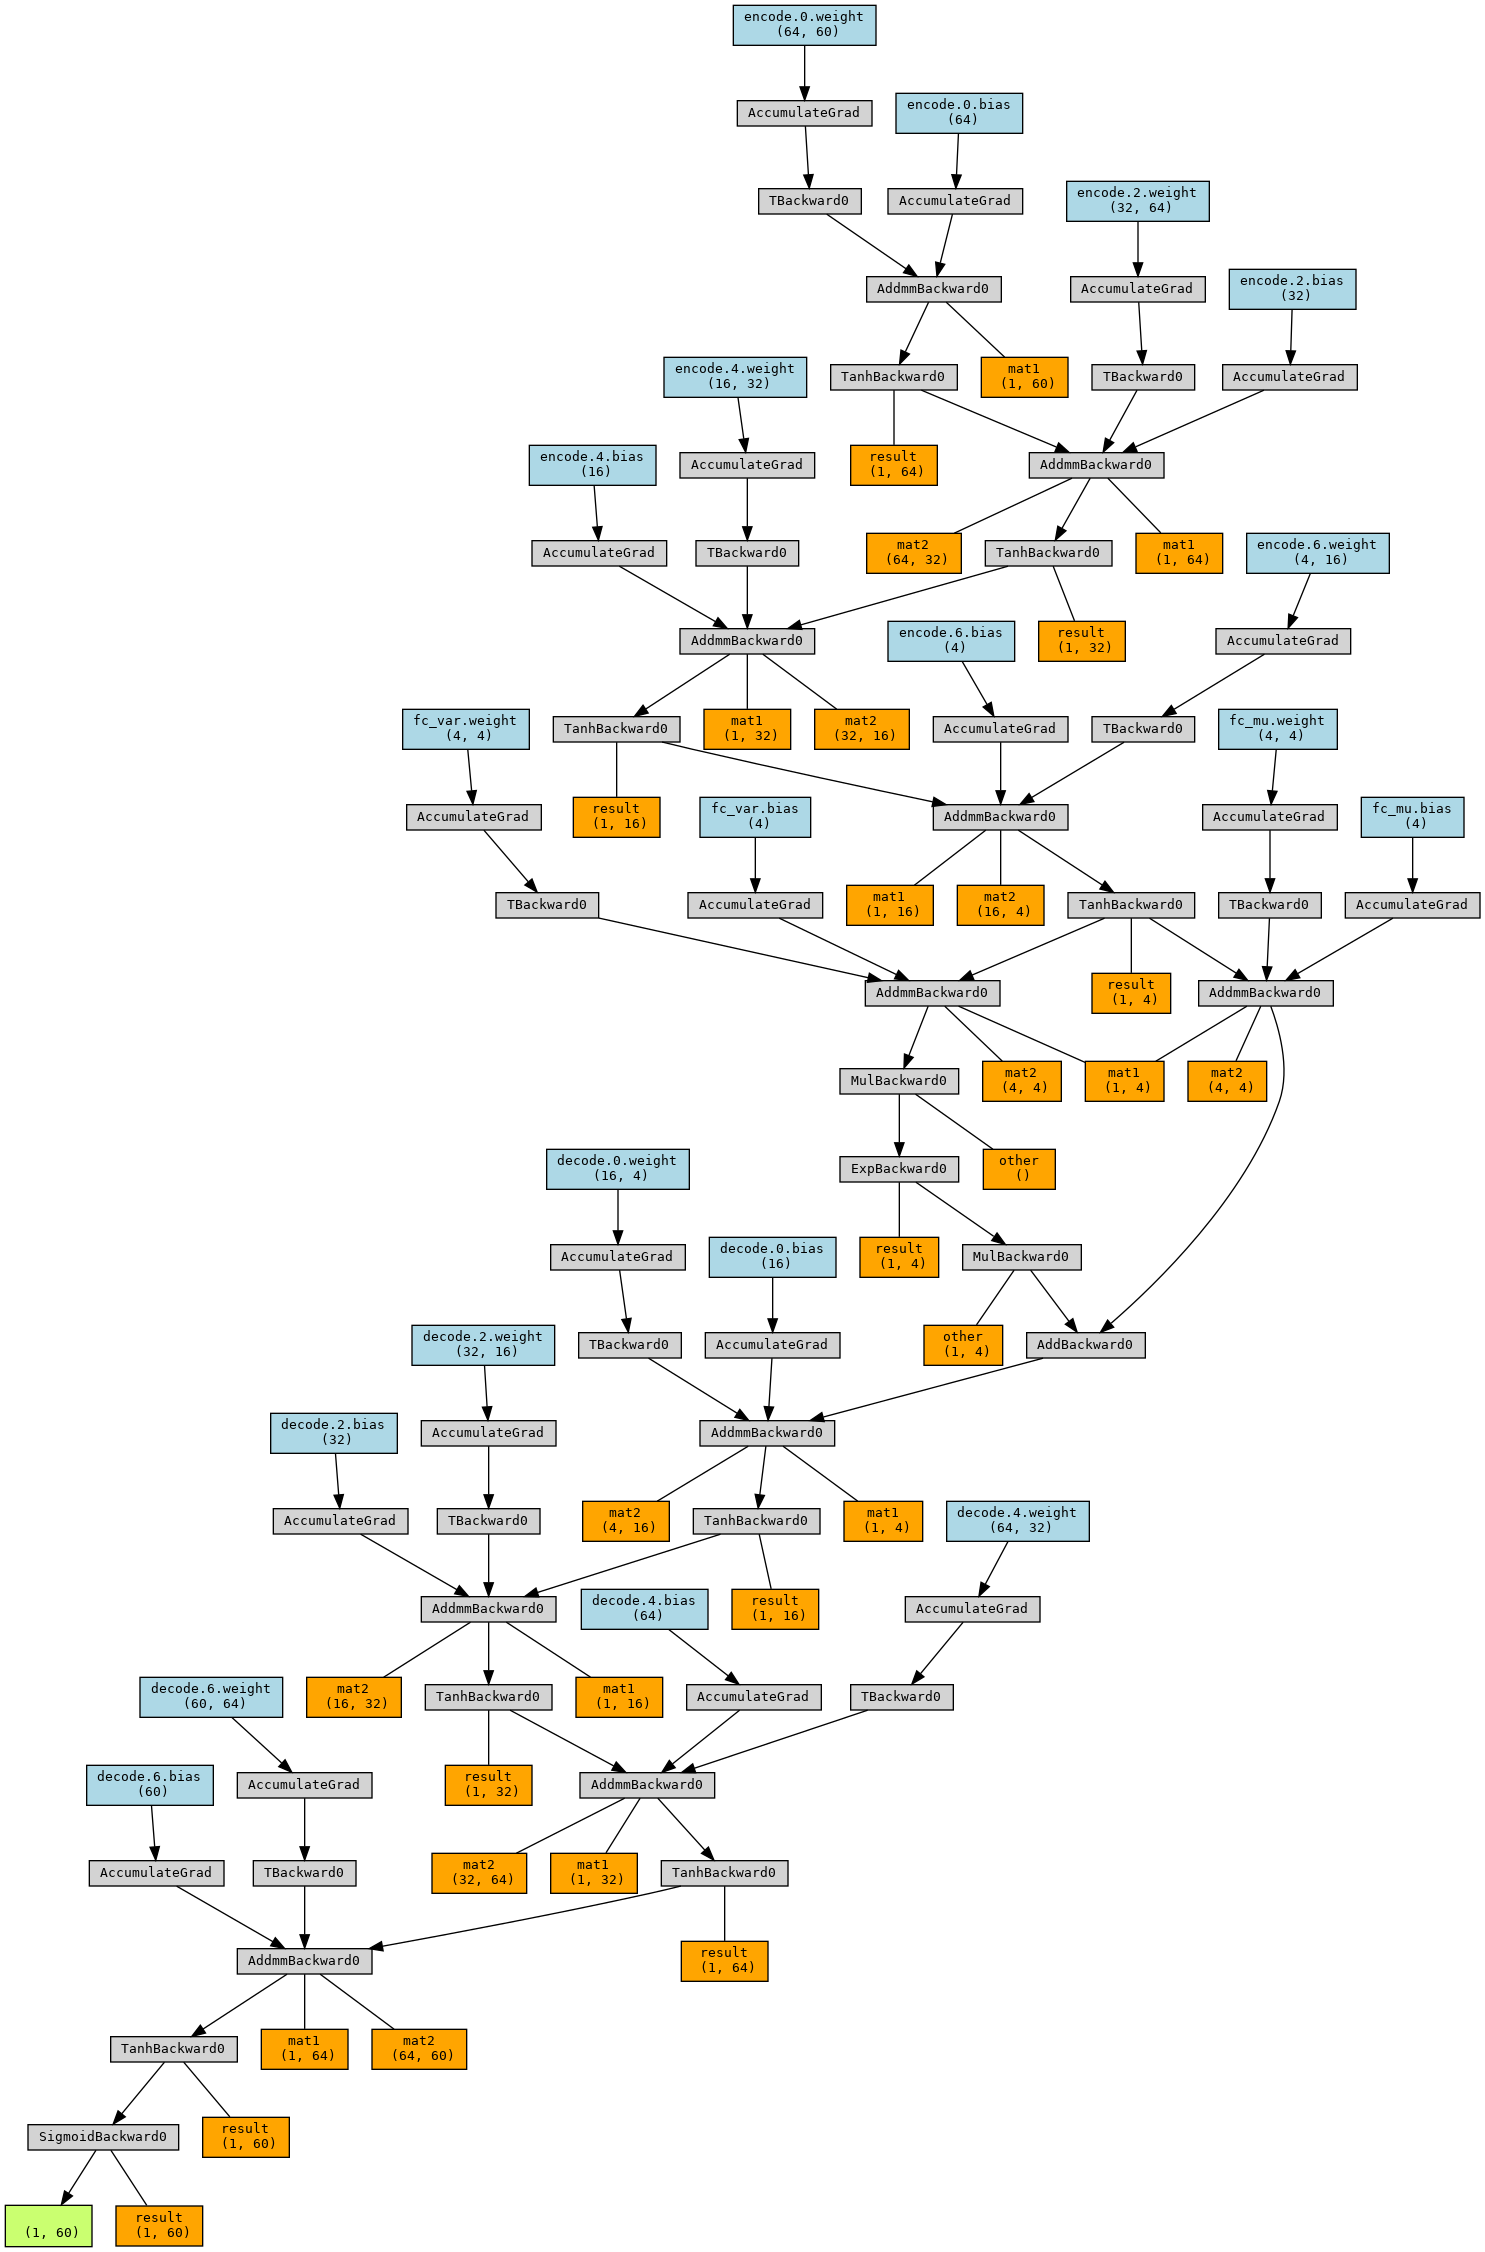

In [20]:
# make image of network
graph = make_dot(
    model(sample_input),
    params=dict(model.named_parameters()),
    show_attrs=False,
    show_saved=True,
)

# save graph
fname = f"{dir_models}/model_network_{tag}"
graph.format = "png"
graph.render(fname)

# delete temporary file
os.remove(f"{fname}")

# show graph
Image(f"{fname}.{graph.format}", width=600)


## 3. Train model

### Helper functions

In [21]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss, recons_loss, kld_loss = 0.0, 0.0, 0.0
    
    # Iterate the dataloader
    for x in dataloader: 
        # Evaluate loss
        x = x.to(device)
        x_hat = vae(x)
        loss, recons, kld = vae.loss_function(x, x_hat)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        recons_loss += recons.item()
        kld_loss += kld.item()
    
    # Return loss
    loss = train_loss / len(dataloader.dataset)
    recons_loss = recons_loss / len(dataloader.dataset)
    kld_loss = kld_loss / len(dataloader.dataset)
    return loss, recons_loss, kld_loss


In [22]:
### Testing function
def test_epoch(vae, device, dataloader, verbose=False):
    
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss, recons_loss, kld_loss = 0.0, 0.0, 0.0
    
    with torch.no_grad(): # No need to track the gradients
        for x in dataloader:
            x = x.to(device)
            x_hat = vae(x)
            loss, recons, kld  = vae.loss_function(x, x_hat)
            val_loss += loss.item()
            recons_loss += recons.item()
            kld_loss += kld.item()

        val_loss /= len(dataloader.dataset)
        recons_loss /= len(dataloader.dataset)
        kld_loss /= len(dataloader.dataset)

        if verbose:
                print(f"Loss Validation, Reconstruction, KL: ({val_loss:.4e}, {recons_loss:.4e}, {kld_loss:.4e})")

    return val_loss, recons_loss, kld_loss


In [23]:
def plot_latent(autoencoder, data, epoch, tag, perplexity=30, n_iter=10000):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cmap = cmr.take_cmap_colors("cmr.rainforest", 10, cmap_range=(0.1, 0.9))
    fname = f"{dir_figures}/latent-{tag}-epoch_{epoch}"

    # iterate over data loader to get all data
    dat = []
    for i, data in enumerate(data):
        dat.append(data)
    dat = torch.cat(dat)
    z = autoencoder.encoder(dat.to(device))
    z = z.to('cpu').detach().numpy()

    # if number of dimensions (columns) is greater than 2, use t-SN
    title = f"Latent Space (Epoch {epoch})"
    if z.shape[1] > 2:
        title = f"Latent Space (Epoch {epoch}; t-SNE)"
        fname += f"-tsne_p{perplexity}_n{n_iter}"
        mod = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter)
        z = mod.fit_transform(z)
        print(f"Final t-SNE KL divergence: {mod.kl_divergence_:.4f}")
        print(f"Final t-SNE iterations: {mod.n_iter_+1}")
    
    print(z.shape)

    ax.plot(z[:, 0], z[:, 1], color=cmap[1], alpha=0.7, linestyle="", marker="o", markersize=2)

    
    ax.set_xlabel(r"$z_1$")
    ax.set_ylabel(r"$z_2$")
    ax.set_title(title, y=1.02)

    fig.tight_layout()
    fig.savefig(f"{fname}.png", dpi=300)

    return fig, ax


In [24]:
def plot_ae_outputs(autoencoder, epoch, tag, n=5):
    
    fig = plt.figure(figsize=(11, 6))
    axs = fig.subplots(3, n+1)
    fname = f"{dir_figures}/ae_outputs-{tag}-epoch_{epoch}"

    fig.suptitle(f"Epoch {epoch}", fontsize=40, fontweight="bold")
    
    for i in range(n):
        img = train_features[i]
        with torch.no_grad():
            rec_img  = autoencoder(img.to(device))
        # convert tensors to 1D numpy arrays
        img_cpu = img.cpu().numpy()
        rec_img_cpu = rec_img.cpu().numpy()

        # pad tensors to be length of perfect square
        num_square = int(np.ceil(np.sqrt(img_cpu.shape[0])))
        num_add = num_square**2 - img_cpu.shape[0]
        img_cpu = np.pad(img_cpu, (0,num_add), mode='constant', constant_values=0)
        rec_img_cpu = np.pad(rec_img_cpu, (0,num_add), mode='constant', constant_values=0)

        # convert 1D arrays to 2d square arrays with 0 for empty space
        img_cpu = np.reshape(img_cpu, (num_square, num_square))
        rec_img_cpu = np.reshape(rec_img_cpu, (num_square, num_square))

        # difference between original and reconstructed
        diff = img_cpu - rec_img_cpu

        # add figures to plot
        im0 = axs[0, i].imshow(diff, cmap=cmr.fusion, vmin=-0.2, vmax=0.2)
        im1 = axs[1, i].imshow(img_cpu, cmap=cmr.lilac, vmin=0, vmax=1)
        im2 = axs[2, i].imshow(rec_img_cpu, cmap=cmr.lilac, vmin=0, vmax=1)

        # plot elements
        titles = ["Difference", "Original", "Reconstructed"]
        for j in range(3):
            ax = axs[j, i]
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == n//2:
                ax.set_title(titles[j])
        
        # add colorbar and remove axes on last column
        if i == n-1:
            ims = [im0, im1, im2]
            for j in range(3):
                ax = axs[j, -1]
                ax.axis('off')
                fig.colorbar(ims[j], ax=ax, fraction=0.5, aspect=5)
    
    fig.tight_layout()
    fig.savefig(f"{fname}.png", dpi=300)
        
    return fig, axs


### Training

Tag: DI_60-DH_64_32_16-DL_4-WK_0.01-WR_1.0-WF_1.0-LR_0.001-RG_1e-05-BS_256-SD_42


Epochs:   0%|          | 0/500 [00:00<?, ?epoch/s]

Writing data for epoch 0 of 500


/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "


Final t-SNE KL divergence: 1.9211
Final t-SNE iterations: 10000
(8846, 2)
Loss Validation, Reconstruction, KL: (1.7042e-01, 1.4879e-01, 2.1624e-02)
Loss Validation, Reconstruction, KL: (1.5248e-01, 1.3122e-01, 2.1257e-02)
Loss Validation, Reconstruction, KL: (1.4662e-01, 1.2787e-01, 1.8745e-02)
Loss Validation, Reconstruction, KL: (1.4131e-01, 1.2687e-01, 1.4442e-02)
Loss Validation, Reconstruction, KL: (1.3718e-01, 1.2532e-01, 1.1862e-02)
Loss Validation, Reconstruction, KL: (1.3193e-01, 1.2419e-01, 7.7310e-03)
Loss Validation, Reconstruction, KL: (1.2765e-01, 1.2315e-01, 4.5038e-03)
Loss Validation, Reconstruction, KL: (1.2537e-01, 1.2243e-01, 2.9362e-03)
Loss Validation, Reconstruction, KL: (1.2367e-01, 1.2184e-01, 1.8238e-03)
Loss Validation, Reconstruction, KL: (1.2257e-01, 1.2182e-01, 7.5963e-04)
Loss Validation, Reconstruction, KL: (1.2197e-01, 1.2151e-01, 4.5983e-04)
Loss Validation, Reconstruction, KL: (1.2147e-01, 1.2118e-01, 2.8844e-04)
Loss Validation, Reconstruction, KL: (

/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "


Final t-SNE KL divergence: 2.0046
Final t-SNE iterations: 10000
(8846, 2)
Loss Validation, Reconstruction, KL: (1.1916e-01, 1.1535e-01, 3.8158e-03)
Loss Validation, Reconstruction, KL: (1.1799e-01, 1.1467e-01, 3.3127e-03)
Loss Validation, Reconstruction, KL: (1.1722e-01, 1.1339e-01, 3.8260e-03)
Loss Validation, Reconstruction, KL: (1.1725e-01, 1.1288e-01, 4.3654e-03)
Loss Validation, Reconstruction, KL: (1.1654e-01, 1.1238e-01, 4.1651e-03)
Loss Validation, Reconstruction, KL: (1.1675e-01, 1.1263e-01, 4.1210e-03)
Loss Validation, Reconstruction, KL: (1.1634e-01, 1.1173e-01, 4.6090e-03)
Loss Validation, Reconstruction, KL: (1.1649e-01, 1.1182e-01, 4.6680e-03)
Loss Validation, Reconstruction, KL: (1.1669e-01, 1.1174e-01, 4.9431e-03)
Loss Validation, Reconstruction, KL: (1.1604e-01, 1.1117e-01, 4.8750e-03)
Loss Validation, Reconstruction, KL: (1.1608e-01, 1.1119e-01, 4.8817e-03)
Loss Validation, Reconstruction, KL: (1.1570e-01, 1.1065e-01, 5.0502e-03)
Loss Validation, Reconstruction, KL: (

/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "


Final t-SNE KL divergence: 1.9659
Final t-SNE iterations: 10000
(8846, 2)
Loss Validation, Reconstruction, KL: (1.1428e-01, 1.0842e-01, 5.8589e-03)
Loss Validation, Reconstruction, KL: (1.1424e-01, 1.0835e-01, 5.8860e-03)
Loss Validation, Reconstruction, KL: (1.1448e-01, 1.0855e-01, 5.9289e-03)
Loss Validation, Reconstruction, KL: (1.1455e-01, 1.0851e-01, 6.0433e-03)
Loss Validation, Reconstruction, KL: (1.1417e-01, 1.0812e-01, 6.0521e-03)
Loss Validation, Reconstruction, KL: (1.1417e-01, 1.0797e-01, 6.1950e-03)
Loss Validation, Reconstruction, KL: (1.1394e-01, 1.0777e-01, 6.1713e-03)
Loss Validation, Reconstruction, KL: (1.1393e-01, 1.0748e-01, 6.4510e-03)
Loss Validation, Reconstruction, KL: (1.1428e-01, 1.0766e-01, 6.6254e-03)
Loss Validation, Reconstruction, KL: (1.1327e-01, 1.0641e-01, 6.8652e-03)
Loss Validation, Reconstruction, KL: (1.1308e-01, 1.0598e-01, 7.1028e-03)
Loss Validation, Reconstruction, KL: (1.1458e-01, 1.0696e-01, 7.6183e-03)
Loss Validation, Reconstruction, KL: (

/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "


Final t-SNE KL divergence: 1.9758
Final t-SNE iterations: 10000
(8846, 2)
Loss Validation, Reconstruction, KL: (1.0867e-01, 9.8309e-02, 1.0361e-02)
Loss Validation, Reconstruction, KL: (1.0994e-01, 9.8952e-02, 1.0989e-02)
Loss Validation, Reconstruction, KL: (1.0905e-01, 9.8203e-02, 1.0850e-02)
Loss Validation, Reconstruction, KL: (1.0867e-01, 9.8044e-02, 1.0622e-02)
Loss Validation, Reconstruction, KL: (1.0823e-01, 9.7398e-02, 1.0836e-02)
Loss Validation, Reconstruction, KL: (1.0810e-01, 9.7033e-02, 1.1066e-02)
Loss Validation, Reconstruction, KL: (1.0809e-01, 9.6681e-02, 1.1409e-02)
Loss Validation, Reconstruction, KL: (1.0794e-01, 9.6389e-02, 1.1554e-02)
Loss Validation, Reconstruction, KL: (1.0761e-01, 9.6354e-02, 1.1256e-02)
Loss Validation, Reconstruction, KL: (1.0791e-01, 9.6535e-02, 1.1377e-02)
Loss Validation, Reconstruction, KL: (1.0795e-01, 9.6421e-02, 1.1531e-02)
Loss Validation, Reconstruction, KL: (1.0751e-01, 9.6043e-02, 1.1463e-02)
Loss Validation, Reconstruction, KL: (

/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "


Final t-SNE KL divergence: 1.9424
Final t-SNE iterations: 10000
(8846, 2)
Loss Validation, Reconstruction, KL: (1.0513e-01, 9.1921e-02, 1.3205e-02)
Loss Validation, Reconstruction, KL: (1.0535e-01, 9.1906e-02, 1.3440e-02)
Loss Validation, Reconstruction, KL: (1.0532e-01, 9.1470e-02, 1.3852e-02)
Loss Validation, Reconstruction, KL: (1.0513e-01, 9.1527e-02, 1.3602e-02)
Loss Validation, Reconstruction, KL: (1.0435e-01, 9.0256e-02, 1.4098e-02)
Loss Validation, Reconstruction, KL: (1.0450e-01, 9.0258e-02, 1.4239e-02)
Loss Validation, Reconstruction, KL: (1.0400e-01, 8.9952e-02, 1.4053e-02)
Loss Validation, Reconstruction, KL: (1.0469e-01, 9.0682e-02, 1.4010e-02)
Loss Validation, Reconstruction, KL: (1.0387e-01, 8.9731e-02, 1.4137e-02)
Loss Validation, Reconstruction, KL: (1.0350e-01, 8.9385e-02, 1.4117e-02)
Loss Validation, Reconstruction, KL: (1.0423e-01, 8.9971e-02, 1.4262e-02)
Loss Validation, Reconstruction, KL: (1.0372e-01, 8.9069e-02, 1.4655e-02)
Loss Validation, Reconstruction, KL: (

/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "


Final t-SNE KL divergence: 1.9229
Final t-SNE iterations: 10000
(8846, 2)
Loss Validation, Reconstruction, KL: (1.0369e-01, 8.8858e-02, 1.4829e-02)
Loss Validation, Reconstruction, KL: (1.0324e-01, 8.8259e-02, 1.4981e-02)
Loss Validation, Reconstruction, KL: (1.0480e-01, 9.0117e-02, 1.4686e-02)
Loss Validation, Reconstruction, KL: (1.0293e-01, 8.7875e-02, 1.5054e-02)
Loss Validation, Reconstruction, KL: (1.0369e-01, 8.8465e-02, 1.5228e-02)
Loss Validation, Reconstruction, KL: (1.0311e-01, 8.8146e-02, 1.4964e-02)
Loss Validation, Reconstruction, KL: (1.0343e-01, 8.8259e-02, 1.5172e-02)
Loss Validation, Reconstruction, KL: (1.0281e-01, 8.7699e-02, 1.5112e-02)
Loss Validation, Reconstruction, KL: (1.0325e-01, 8.8577e-02, 1.4675e-02)
Loss Validation, Reconstruction, KL: (1.0277e-01, 8.7496e-02, 1.5275e-02)
Loss Validation, Reconstruction, KL: (1.0255e-01, 8.7533e-02, 1.5013e-02)
Loss Validation, Reconstruction, KL: (1.0261e-01, 8.7547e-02, 1.5063e-02)
Loss Validation, Reconstruction, KL: (

/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "


Final t-SNE KL divergence: 1.9604
Final t-SNE iterations: 10000
(8846, 2)
Loss Validation, Reconstruction, KL: (1.0220e-01, 8.7262e-02, 1.4935e-02)
Loss Validation, Reconstruction, KL: (1.0266e-01, 8.7440e-02, 1.5224e-02)
Loss Validation, Reconstruction, KL: (1.0214e-01, 8.7102e-02, 1.5033e-02)
Loss Validation, Reconstruction, KL: (1.0226e-01, 8.7150e-02, 1.5111e-02)
Loss Validation, Reconstruction, KL: (1.0255e-01, 8.7036e-02, 1.5514e-02)
Loss Validation, Reconstruction, KL: (1.0208e-01, 8.6742e-02, 1.5337e-02)
Loss Validation, Reconstruction, KL: (1.0207e-01, 8.6689e-02, 1.5376e-02)
Loss Validation, Reconstruction, KL: (1.0231e-01, 8.7375e-02, 1.4938e-02)
Loss Validation, Reconstruction, KL: (1.0240e-01, 8.7296e-02, 1.5105e-02)
Loss Validation, Reconstruction, KL: (1.0217e-01, 8.6715e-02, 1.5458e-02)
Loss Validation, Reconstruction, KL: (1.0249e-01, 8.7370e-02, 1.5122e-02)
Loss Validation, Reconstruction, KL: (1.0239e-01, 8.7022e-02, 1.5371e-02)
Loss Validation, Reconstruction, KL: (

/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "


Final t-SNE KL divergence: 1.9125
Final t-SNE iterations: 10000
(8846, 2)
Loss Validation, Reconstruction, KL: (1.0213e-01, 8.6385e-02, 1.5749e-02)
Loss Validation, Reconstruction, KL: (1.0220e-01, 8.6760e-02, 1.5437e-02)
Loss Validation, Reconstruction, KL: (1.0213e-01, 8.6845e-02, 1.5282e-02)
Loss Validation, Reconstruction, KL: (1.0171e-01, 8.6108e-02, 1.5602e-02)
Loss Validation, Reconstruction, KL: (1.0224e-01, 8.7081e-02, 1.5158e-02)
Loss Validation, Reconstruction, KL: (1.0157e-01, 8.5737e-02, 1.5837e-02)
Loss Validation, Reconstruction, KL: (1.0203e-01, 8.6878e-02, 1.5152e-02)
Loss Validation, Reconstruction, KL: (1.0128e-01, 8.5836e-02, 1.5448e-02)
Loss Validation, Reconstruction, KL: (1.0193e-01, 8.6272e-02, 1.5662e-02)
Loss Validation, Reconstruction, KL: (1.0209e-01, 8.6198e-02, 1.5888e-02)
Loss Validation, Reconstruction, KL: (1.0191e-01, 8.6489e-02, 1.5417e-02)
Loss Validation, Reconstruction, KL: (1.0217e-01, 8.6217e-02, 1.5951e-02)
Loss Validation, Reconstruction, KL: (

/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "


Final t-SNE KL divergence: 1.9466
Final t-SNE iterations: 8950
(8846, 2)
Loss Validation, Reconstruction, KL: (1.0119e-01, 8.4972e-02, 1.6222e-02)
Loss Validation, Reconstruction, KL: (1.0118e-01, 8.4697e-02, 1.6484e-02)
Loss Validation, Reconstruction, KL: (1.0133e-01, 8.5777e-02, 1.5549e-02)
Loss Validation, Reconstruction, KL: (1.0078e-01, 8.4239e-02, 1.6537e-02)
Loss Validation, Reconstruction, KL: (1.0114e-01, 8.4383e-02, 1.6760e-02)
Loss Validation, Reconstruction, KL: (1.0105e-01, 8.4283e-02, 1.6771e-02)
Loss Validation, Reconstruction, KL: (1.0094e-01, 8.4404e-02, 1.6535e-02)
Loss Validation, Reconstruction, KL: (1.0107e-01, 8.4736e-02, 1.6329e-02)
Loss Validation, Reconstruction, KL: (1.0026e-01, 8.4162e-02, 1.6100e-02)
Loss Validation, Reconstruction, KL: (1.0075e-01, 8.3634e-02, 1.7115e-02)
Loss Validation, Reconstruction, KL: (1.0027e-01, 8.3405e-02, 1.6867e-02)
Loss Validation, Reconstruction, KL: (1.0056e-01, 8.3608e-02, 1.6957e-02)
Loss Validation, Reconstruction, KL: (1

/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "


Final t-SNE KL divergence: 1.8781
Final t-SNE iterations: 10000
(8846, 2)
Loss Validation, Reconstruction, KL: (9.8438e-02, 7.9270e-02, 1.9168e-02)
Loss Validation, Reconstruction, KL: (9.8106e-02, 7.9305e-02, 1.8801e-02)
Loss Validation, Reconstruction, KL: (9.8692e-02, 7.8593e-02, 2.0100e-02)
Loss Validation, Reconstruction, KL: (9.8459e-02, 7.8375e-02, 2.0083e-02)
Loss Validation, Reconstruction, KL: (9.8213e-02, 7.8834e-02, 1.9380e-02)
Loss Validation, Reconstruction, KL: (9.7385e-02, 7.7399e-02, 1.9987e-02)
Loss Validation, Reconstruction, KL: (9.7656e-02, 7.8471e-02, 1.9185e-02)
Loss Validation, Reconstruction, KL: (9.7370e-02, 7.6866e-02, 2.0504e-02)
Loss Validation, Reconstruction, KL: (9.9509e-02, 7.9956e-02, 1.9553e-02)
Loss Validation, Reconstruction, KL: (9.6621e-02, 7.6475e-02, 2.0146e-02)
Loss Validation, Reconstruction, KL: (9.8270e-02, 7.8389e-02, 1.9881e-02)
Loss Validation, Reconstruction, KL: (9.7739e-02, 7.6722e-02, 2.1017e-02)
Loss Validation, Reconstruction, KL: (

/tmp/ipykernel_2432242/597181068.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(11, 6))
/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "


Final t-SNE KL divergence: 1.8252
Final t-SNE iterations: 10000
(8846, 2)
Loss Validation, Reconstruction, KL: (9.4669e-02, 7.3289e-02, 2.1380e-02)
Loss Validation, Reconstruction, KL: (9.4377e-02, 7.1972e-02, 2.2405e-02)
Loss Validation, Reconstruction, KL: (9.4601e-02, 7.2500e-02, 2.2101e-02)
Loss Validation, Reconstruction, KL: (9.4272e-02, 7.1412e-02, 2.2860e-02)
Loss Validation, Reconstruction, KL: (9.3633e-02, 7.1029e-02, 2.2603e-02)
Loss Validation, Reconstruction, KL: (9.3105e-02, 7.0624e-02, 2.2481e-02)
Loss Validation, Reconstruction, KL: (9.3637e-02, 7.1506e-02, 2.2130e-02)
Loss Validation, Reconstruction, KL: (9.3735e-02, 7.1050e-02, 2.2685e-02)
Loss Validation, Reconstruction, KL: (9.3460e-02, 7.1122e-02, 2.2337e-02)
Loss Validation, Reconstruction, KL: (9.3003e-02, 7.0417e-02, 2.2587e-02)
Loss Validation, Reconstruction, KL: (9.2499e-02, 6.9757e-02, 2.2742e-02)
Loss Validation, Reconstruction, KL: (9.3206e-02, 7.0093e-02, 2.3113e-02)
Loss Validation, Reconstruction, KL: (

/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "


Final t-SNE KL divergence: 1.7936
Final t-SNE iterations: 10000
(8846, 2)
Loss Validation, Reconstruction, KL: (9.2194e-02, 6.8457e-02, 2.3738e-02)
Loss Validation, Reconstruction, KL: (9.2296e-02, 6.8209e-02, 2.4086e-02)
Loss Validation, Reconstruction, KL: (9.0913e-02, 6.6853e-02, 2.4060e-02)
Loss Validation, Reconstruction, KL: (9.2601e-02, 6.8046e-02, 2.4555e-02)
Loss Validation, Reconstruction, KL: (9.1904e-02, 6.7774e-02, 2.4130e-02)
Loss Validation, Reconstruction, KL: (9.1504e-02, 6.8285e-02, 2.3219e-02)
Loss Validation, Reconstruction, KL: (9.1860e-02, 6.7767e-02, 2.4094e-02)
Loss Validation, Reconstruction, KL: (9.2404e-02, 6.8420e-02, 2.3983e-02)
Loss Validation, Reconstruction, KL: (9.1283e-02, 6.6913e-02, 2.4370e-02)
Loss Validation, Reconstruction, KL: (9.0667e-02, 6.6713e-02, 2.3953e-02)
Loss Validation, Reconstruction, KL: (9.2391e-02, 6.8380e-02, 2.4011e-02)
Loss Validation, Reconstruction, KL: (9.1099e-02, 6.7974e-02, 2.3125e-02)
Loss Validation, Reconstruction, KL: (

/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "


Final t-SNE KL divergence: 1.7678
Final t-SNE iterations: 10000
(8846, 2)
Loss Validation, Reconstruction, KL: (9.0812e-02, 6.6290e-02, 2.4522e-02)
Loss Validation, Reconstruction, KL: (9.0230e-02, 6.5416e-02, 2.4814e-02)
Loss Validation, Reconstruction, KL: (9.0039e-02, 6.5617e-02, 2.4422e-02)
Loss Validation, Reconstruction, KL: (9.0832e-02, 6.6681e-02, 2.4151e-02)
Loss Validation, Reconstruction, KL: (8.9894e-02, 6.5297e-02, 2.4597e-02)
Loss Validation, Reconstruction, KL: (9.0457e-02, 6.6372e-02, 2.4085e-02)
Loss Validation, Reconstruction, KL: (9.0396e-02, 6.6036e-02, 2.4360e-02)
Loss Validation, Reconstruction, KL: (9.0024e-02, 6.5530e-02, 2.4494e-02)
Loss Validation, Reconstruction, KL: (9.1084e-02, 6.6319e-02, 2.4765e-02)
Loss Validation, Reconstruction, KL: (9.0616e-02, 6.6022e-02, 2.4594e-02)
Loss Validation, Reconstruction, KL: (9.0210e-02, 6.6158e-02, 2.4052e-02)
Loss Validation, Reconstruction, KL: (9.0453e-02, 6.5883e-02, 2.4570e-02)
Loss Validation, Reconstruction, KL: (

/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "


Final t-SNE KL divergence: 1.8264
Final t-SNE iterations: 10000
(8846, 2)
Loss Validation, Reconstruction, KL: (8.9626e-02, 6.5258e-02, 2.4369e-02)
Loss Validation, Reconstruction, KL: (8.9347e-02, 6.4324e-02, 2.5023e-02)
Loss Validation, Reconstruction, KL: (8.8922e-02, 6.4203e-02, 2.4720e-02)
Loss Validation, Reconstruction, KL: (8.8818e-02, 6.4292e-02, 2.4527e-02)
Loss Validation, Reconstruction, KL: (8.8889e-02, 6.4200e-02, 2.4689e-02)
Loss Validation, Reconstruction, KL: (8.9164e-02, 6.3634e-02, 2.5529e-02)
Loss Validation, Reconstruction, KL: (8.8628e-02, 6.3724e-02, 2.4904e-02)
Loss Validation, Reconstruction, KL: (8.8900e-02, 6.3359e-02, 2.5541e-02)
Loss Validation, Reconstruction, KL: (8.8730e-02, 6.3725e-02, 2.5004e-02)
Loss Validation, Reconstruction, KL: (8.8306e-02, 6.3081e-02, 2.5225e-02)
Loss Validation, Reconstruction, KL: (8.8912e-02, 6.3493e-02, 2.5419e-02)
Loss Validation, Reconstruction, KL: (8.8333e-02, 6.3352e-02, 2.4981e-02)
Loss Validation, Reconstruction, KL: (

/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "


Final t-SNE KL divergence: 1.7778
Final t-SNE iterations: 10000
(8846, 2)
Loss Validation, Reconstruction, KL: (8.8023e-02, 6.2488e-02, 2.5535e-02)
Loss Validation, Reconstruction, KL: (8.7683e-02, 6.2550e-02, 2.5134e-02)
Loss Validation, Reconstruction, KL: (8.7702e-02, 6.2021e-02, 2.5680e-02)
Loss Validation, Reconstruction, KL: (8.7641e-02, 6.1564e-02, 2.6077e-02)
Loss Validation, Reconstruction, KL: (8.7667e-02, 6.1780e-02, 2.5886e-02)
Loss Validation, Reconstruction, KL: (8.7408e-02, 6.2074e-02, 2.5334e-02)
Loss Validation, Reconstruction, KL: (8.7035e-02, 6.1445e-02, 2.5591e-02)
Loss Validation, Reconstruction, KL: (8.7352e-02, 6.1936e-02, 2.5416e-02)
Loss Validation, Reconstruction, KL: (8.8039e-02, 6.2668e-02, 2.5371e-02)
Loss Validation, Reconstruction, KL: (8.6813e-02, 6.0921e-02, 2.5892e-02)
Loss Validation, Reconstruction, KL: (8.7074e-02, 6.1156e-02, 2.5918e-02)
Loss Validation, Reconstruction, KL: (8.7029e-02, 6.1001e-02, 2.6028e-02)
Loss Validation, Reconstruction, KL: (

/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "


Final t-SNE KL divergence: 1.7822
Final t-SNE iterations: 10000
(8846, 2)
Loss Validation, Reconstruction, KL: (8.6370e-02, 6.0442e-02, 2.5928e-02)
Loss Validation, Reconstruction, KL: (8.6401e-02, 6.0747e-02, 2.5654e-02)
Loss Validation, Reconstruction, KL: (8.6458e-02, 6.0529e-02, 2.5929e-02)
Loss Validation, Reconstruction, KL: (8.6188e-02, 6.0363e-02, 2.5825e-02)
Loss Validation, Reconstruction, KL: (8.6431e-02, 5.9517e-02, 2.6914e-02)
Loss Validation, Reconstruction, KL: (8.6361e-02, 6.0127e-02, 2.6234e-02)
Loss Validation, Reconstruction, KL: (8.6466e-02, 6.0836e-02, 2.5631e-02)
Loss Validation, Reconstruction, KL: (8.6345e-02, 6.0453e-02, 2.5892e-02)
Loss Validation, Reconstruction, KL: (8.6729e-02, 5.9808e-02, 2.6921e-02)
Loss Validation, Reconstruction, KL: (8.6004e-02, 5.9550e-02, 2.6454e-02)
Loss Validation, Reconstruction, KL: (8.6889e-02, 6.1262e-02, 2.5626e-02)
Loss Validation, Reconstruction, KL: (8.6042e-02, 5.9817e-02, 2.6226e-02)
Loss Validation, Reconstruction, KL: (

/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "


Final t-SNE KL divergence: 1.7877
Final t-SNE iterations: 10000
(8846, 2)
Loss Validation, Reconstruction, KL: (8.6017e-02, 5.9036e-02, 2.6981e-02)
Loss Validation, Reconstruction, KL: (8.5337e-02, 5.8605e-02, 2.6732e-02)
Loss Validation, Reconstruction, KL: (8.6086e-02, 5.9423e-02, 2.6663e-02)
Loss Validation, Reconstruction, KL: (8.6444e-02, 5.9529e-02, 2.6915e-02)
Loss Validation, Reconstruction, KL: (8.6212e-02, 5.9373e-02, 2.6839e-02)
Loss Validation, Reconstruction, KL: (8.7420e-02, 6.0244e-02, 2.7176e-02)
Loss Validation, Reconstruction, KL: (8.5298e-02, 5.8531e-02, 2.6768e-02)
Loss Validation, Reconstruction, KL: (8.4794e-02, 5.7903e-02, 2.6891e-02)
Loss Validation, Reconstruction, KL: (8.5051e-02, 5.8383e-02, 2.6667e-02)
Loss Validation, Reconstruction, KL: (8.5677e-02, 5.8604e-02, 2.7074e-02)
Loss Validation, Reconstruction, KL: (8.4967e-02, 5.7911e-02, 2.7056e-02)
Loss Validation, Reconstruction, KL: (8.5065e-02, 5.8329e-02, 2.6736e-02)
Loss Validation, Reconstruction, KL: (

/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "


Final t-SNE KL divergence: 1.8307
Final t-SNE iterations: 10000
(8846, 2)
Loss Validation, Reconstruction, KL: (8.5080e-02, 5.7618e-02, 2.7462e-02)
Loss Validation, Reconstruction, KL: (8.4822e-02, 5.7774e-02, 2.7047e-02)
Loss Validation, Reconstruction, KL: (8.4944e-02, 5.8064e-02, 2.6880e-02)
Loss Validation, Reconstruction, KL: (8.5749e-02, 5.7738e-02, 2.8011e-02)
Loss Validation, Reconstruction, KL: (8.4975e-02, 5.7910e-02, 2.7065e-02)
Loss Validation, Reconstruction, KL: (8.4801e-02, 5.7989e-02, 2.6812e-02)
Loss Validation, Reconstruction, KL: (8.4724e-02, 5.7793e-02, 2.6932e-02)
Loss Validation, Reconstruction, KL: (8.4630e-02, 5.7403e-02, 2.7226e-02)
Loss Validation, Reconstruction, KL: (8.5420e-02, 5.8276e-02, 2.7145e-02)
Loss Validation, Reconstruction, KL: (8.4667e-02, 5.7217e-02, 2.7450e-02)
Loss Validation, Reconstruction, KL: (8.4010e-02, 5.7032e-02, 2.6979e-02)
Loss Validation, Reconstruction, KL: (8.4029e-02, 5.6939e-02, 2.7090e-02)
Loss Validation, Reconstruction, KL: (

/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "


Final t-SNE KL divergence: 1.7912
Final t-SNE iterations: 10000
(8846, 2)
Loss Validation, Reconstruction, KL: (8.4181e-02, 5.7233e-02, 2.6948e-02)
Loss Validation, Reconstruction, KL: (8.4138e-02, 5.6751e-02, 2.7387e-02)
Loss Validation, Reconstruction, KL: (8.3907e-02, 5.6349e-02, 2.7558e-02)
Loss Validation, Reconstruction, KL: (8.4365e-02, 5.7744e-02, 2.6621e-02)
Loss Validation, Reconstruction, KL: (8.4339e-02, 5.6917e-02, 2.7422e-02)
Loss Validation, Reconstruction, KL: (8.4289e-02, 5.6672e-02, 2.7617e-02)
Loss Validation, Reconstruction, KL: (8.3787e-02, 5.6385e-02, 2.7403e-02)
Loss Validation, Reconstruction, KL: (8.4398e-02, 5.6804e-02, 2.7594e-02)
Loss Validation, Reconstruction, KL: (8.4337e-02, 5.7123e-02, 2.7215e-02)
Loss Validation, Reconstruction, KL: (8.4154e-02, 5.6671e-02, 2.7483e-02)
Loss Validation, Reconstruction, KL: (8.3999e-02, 5.7092e-02, 2.6907e-02)
Loss Validation, Reconstruction, KL: (8.4375e-02, 5.7273e-02, 2.7102e-02)
Loss Validation, Reconstruction, KL: (

/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "


Final t-SNE KL divergence: 1.7570
Final t-SNE iterations: 10000
(8846, 2)
Loss Validation, Reconstruction, KL: (8.4499e-02, 5.6534e-02, 2.7966e-02)
Loss Validation, Reconstruction, KL: (8.3489e-02, 5.5905e-02, 2.7585e-02)
Loss Validation, Reconstruction, KL: (8.4080e-02, 5.6578e-02, 2.7502e-02)
Loss Validation, Reconstruction, KL: (8.4122e-02, 5.6209e-02, 2.7913e-02)
Loss Validation, Reconstruction, KL: (8.4192e-02, 5.6313e-02, 2.7879e-02)
Loss Validation, Reconstruction, KL: (8.3422e-02, 5.5555e-02, 2.7867e-02)
Loss Validation, Reconstruction, KL: (8.3476e-02, 5.5833e-02, 2.7644e-02)
Loss Validation, Reconstruction, KL: (8.4129e-02, 5.6263e-02, 2.7866e-02)
Loss Validation, Reconstruction, KL: (8.4085e-02, 5.6494e-02, 2.7591e-02)
Loss Validation, Reconstruction, KL: (8.3280e-02, 5.5642e-02, 2.7638e-02)
Loss Validation, Reconstruction, KL: (8.3490e-02, 5.5662e-02, 2.7828e-02)
Loss Validation, Reconstruction, KL: (8.4323e-02, 5.6590e-02, 2.7733e-02)
Loss Validation, Reconstruction, KL: (

/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "


Final t-SNE KL divergence: 1.8064
Final t-SNE iterations: 10000
(8846, 2)


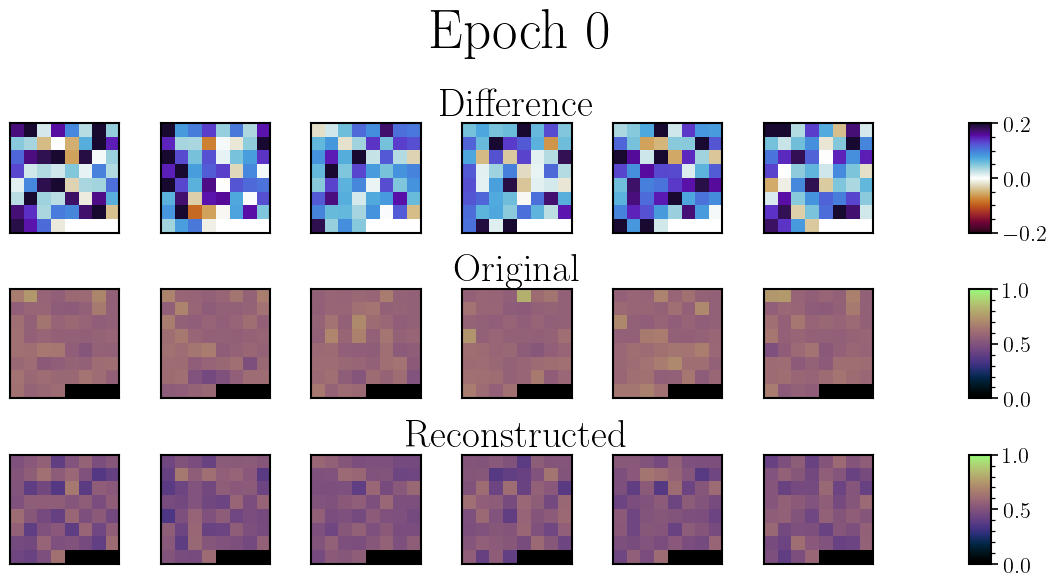

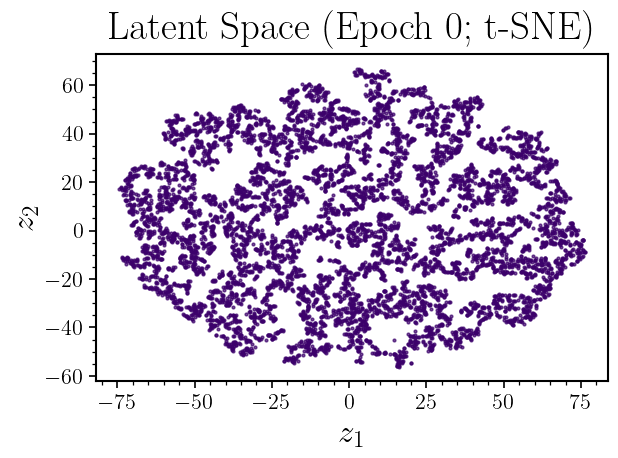

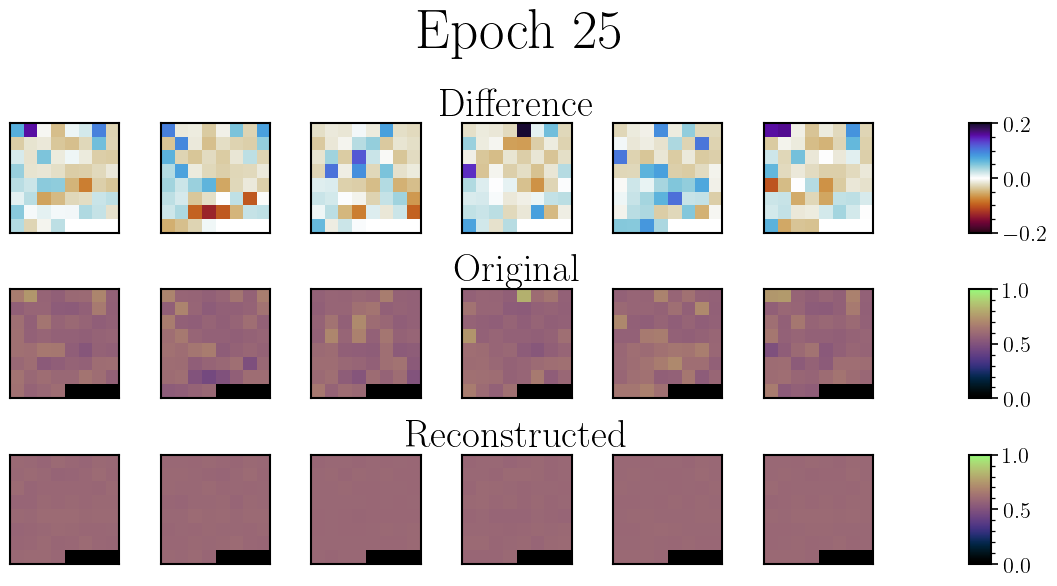

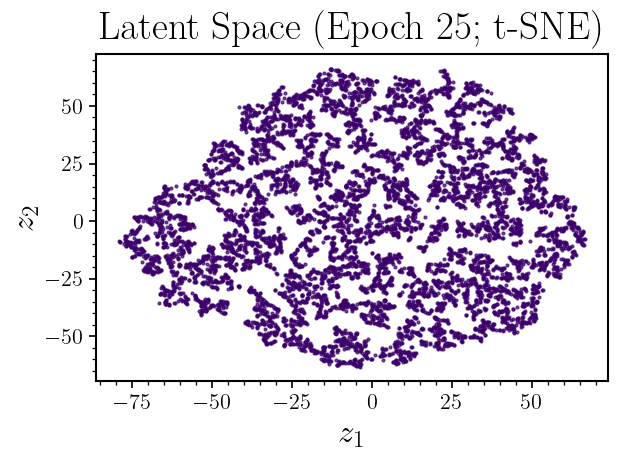

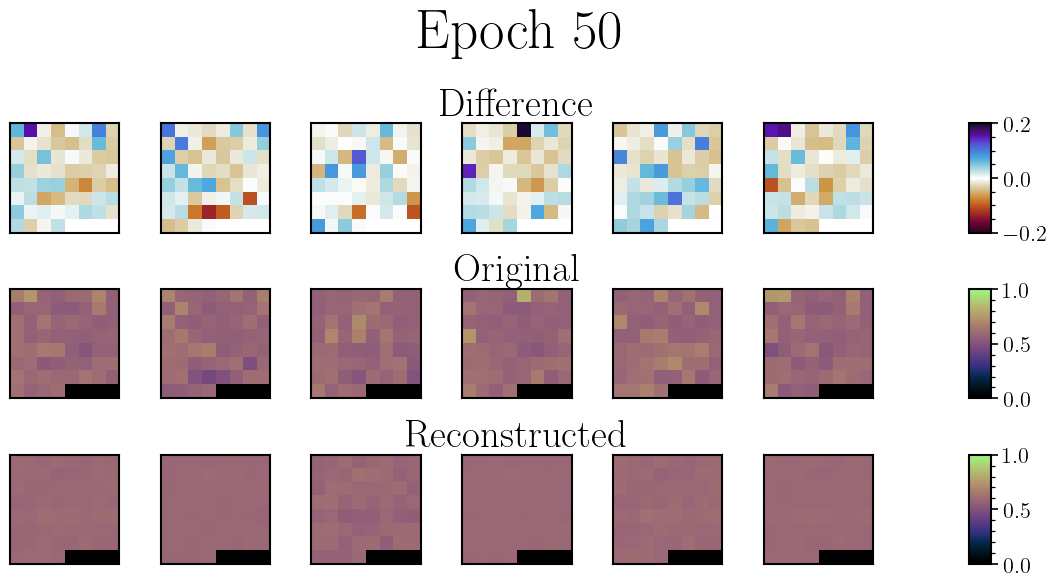

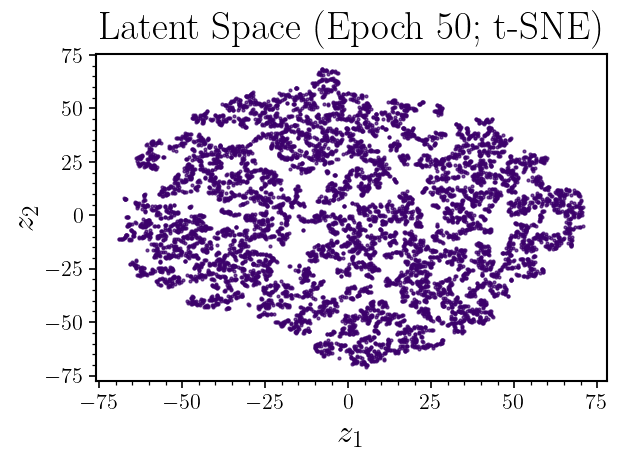

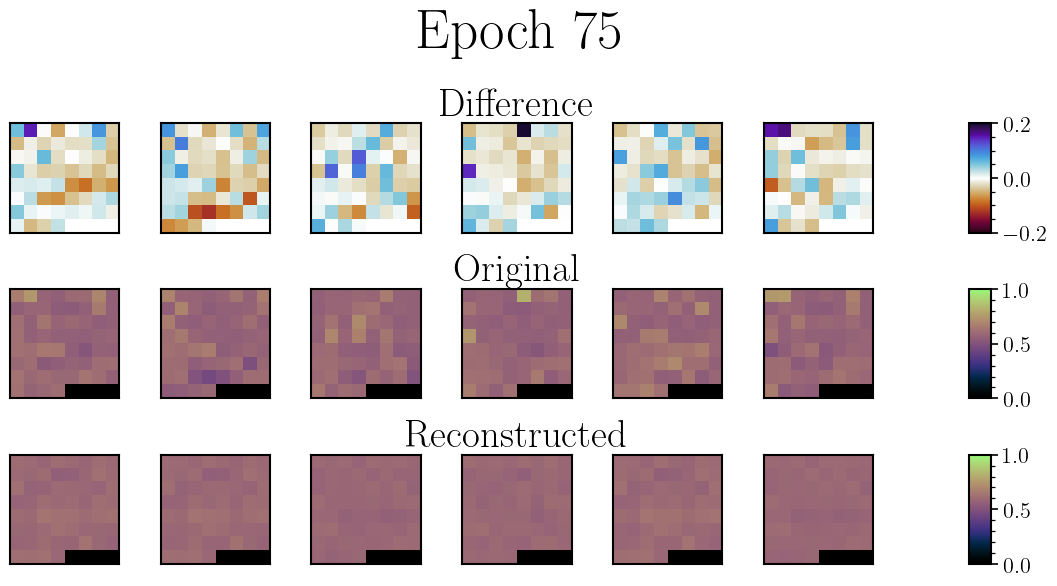

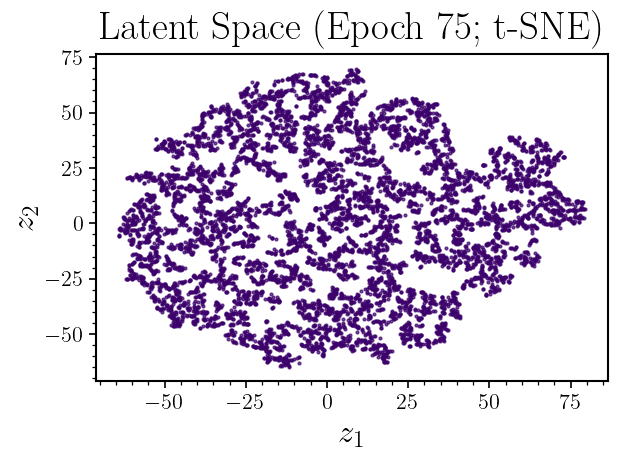

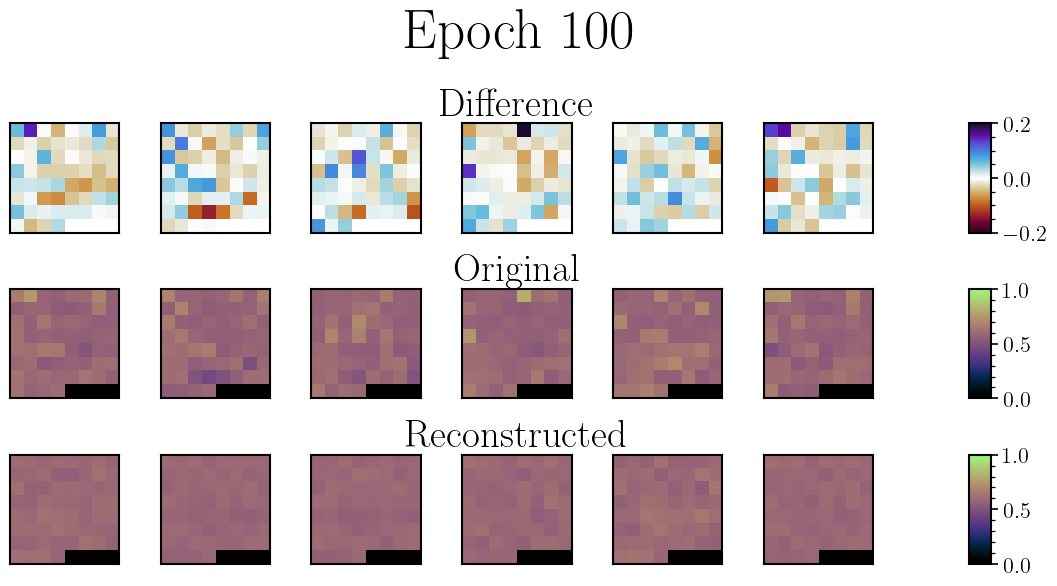

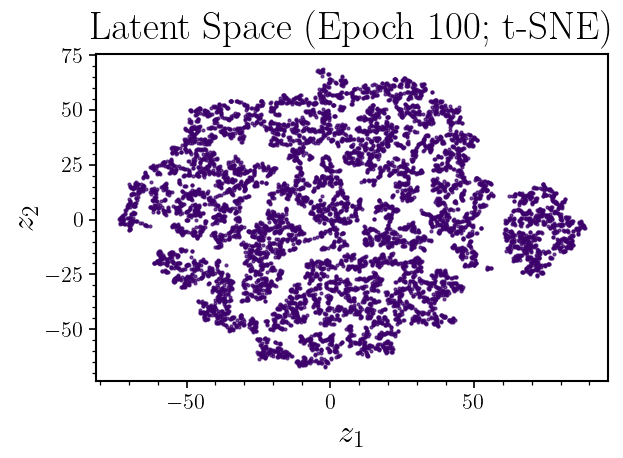

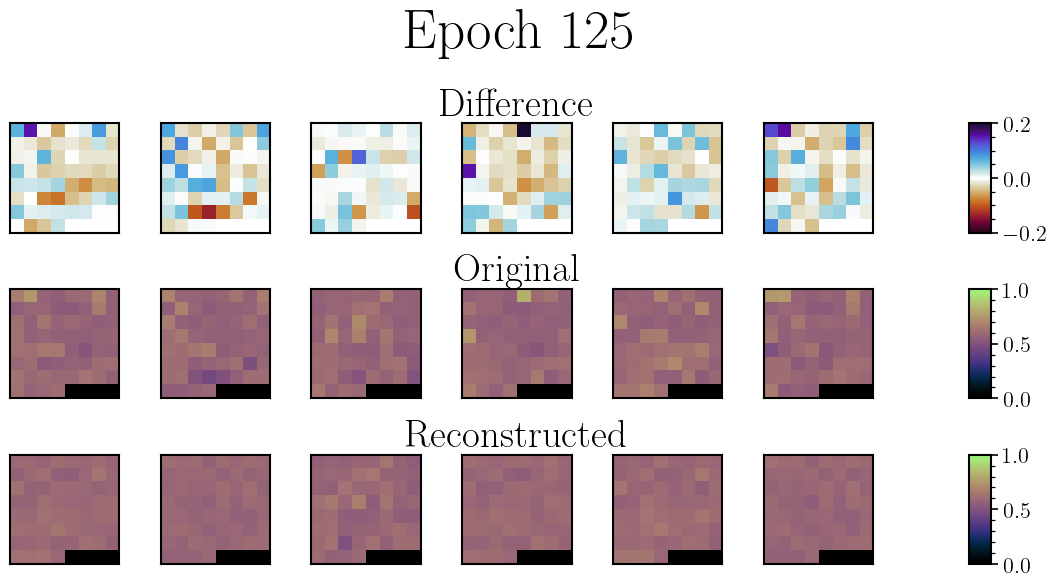

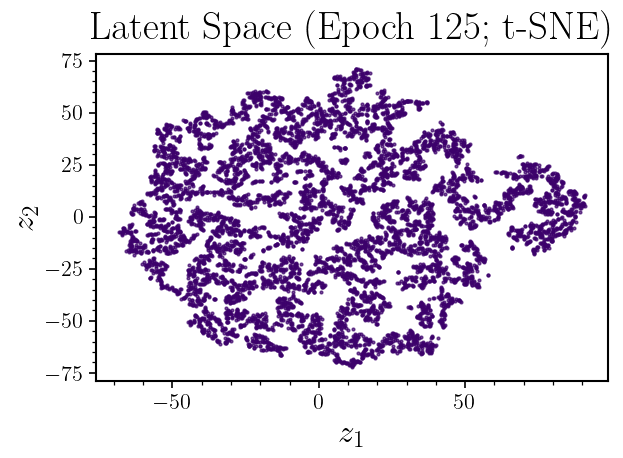

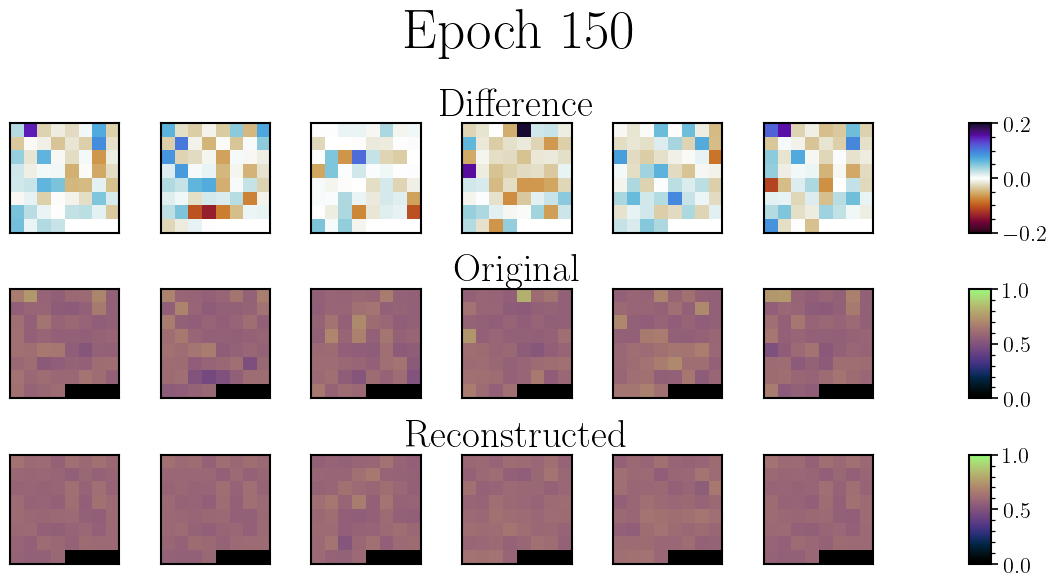

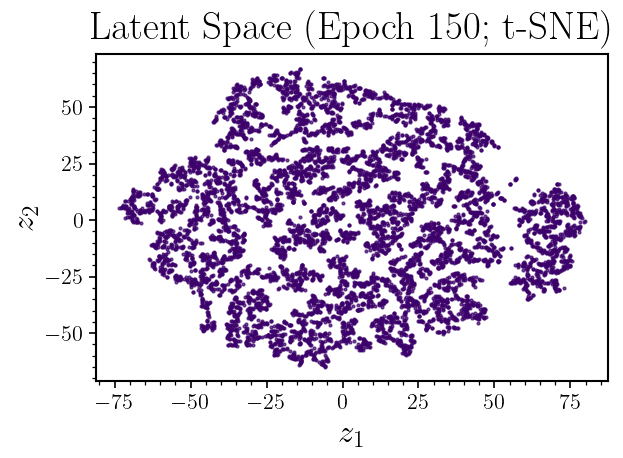

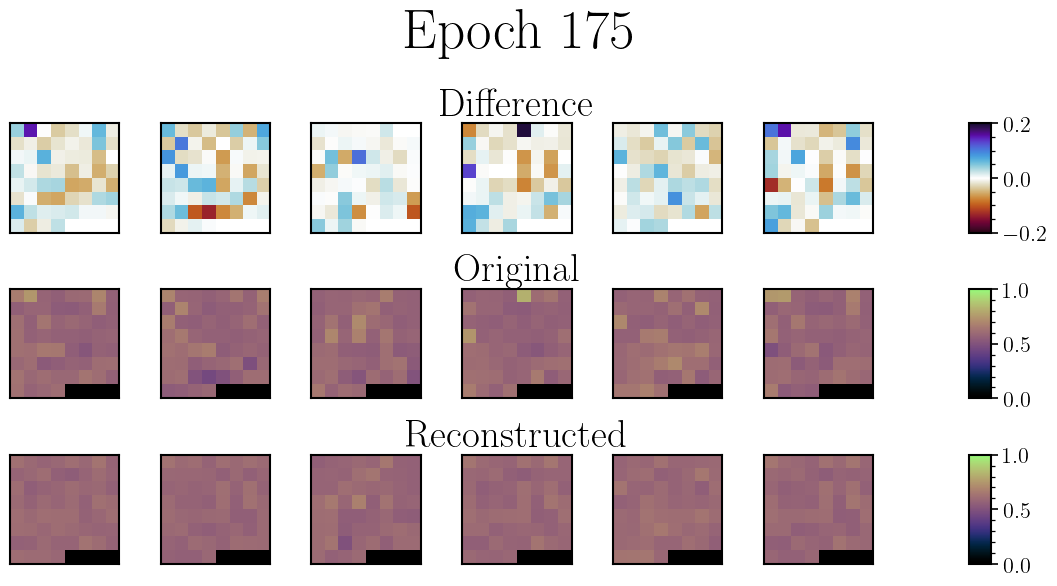

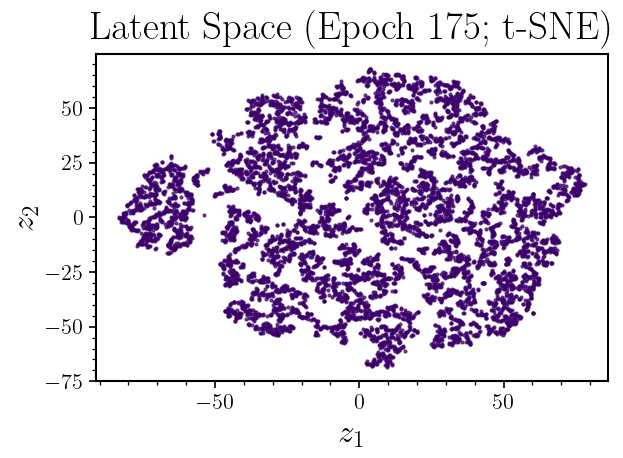

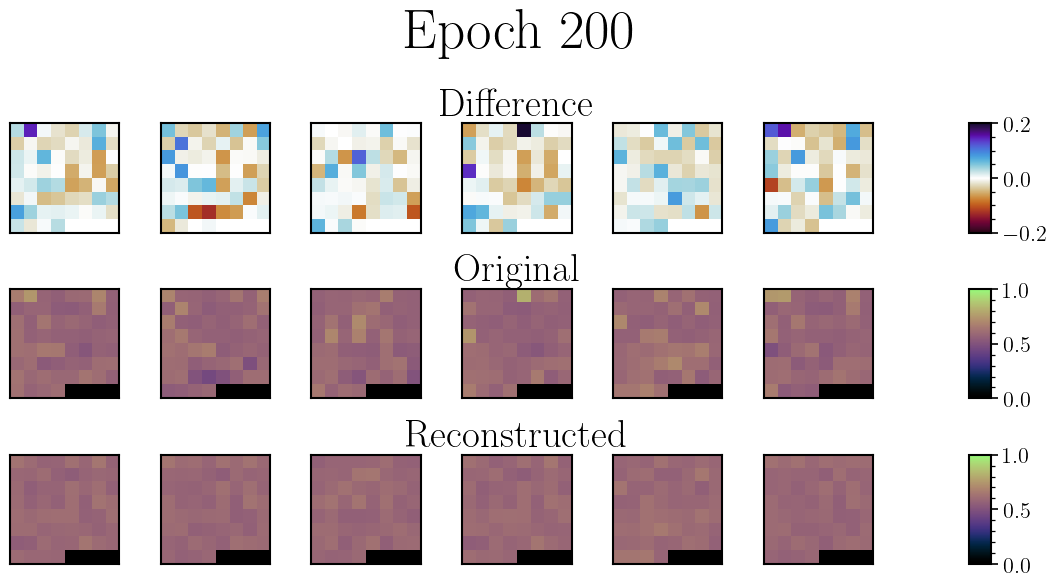

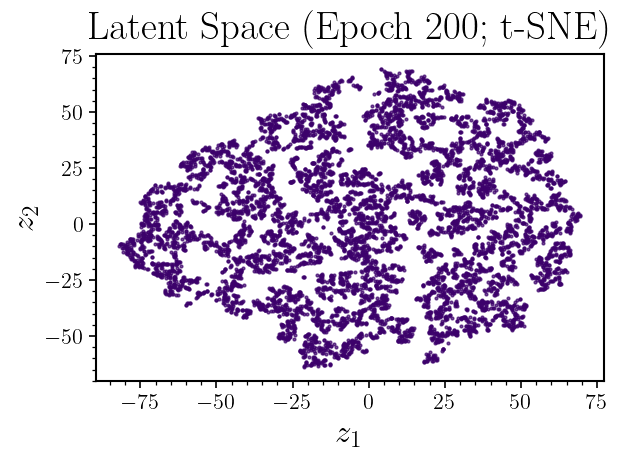

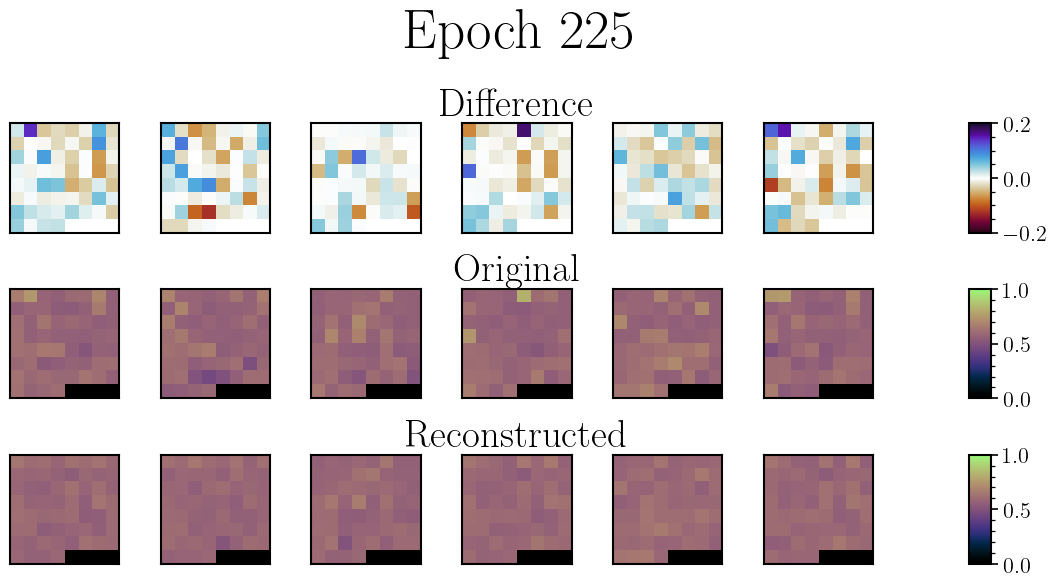

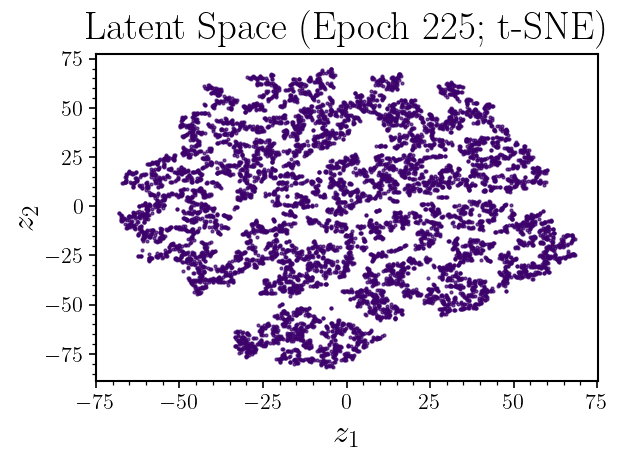

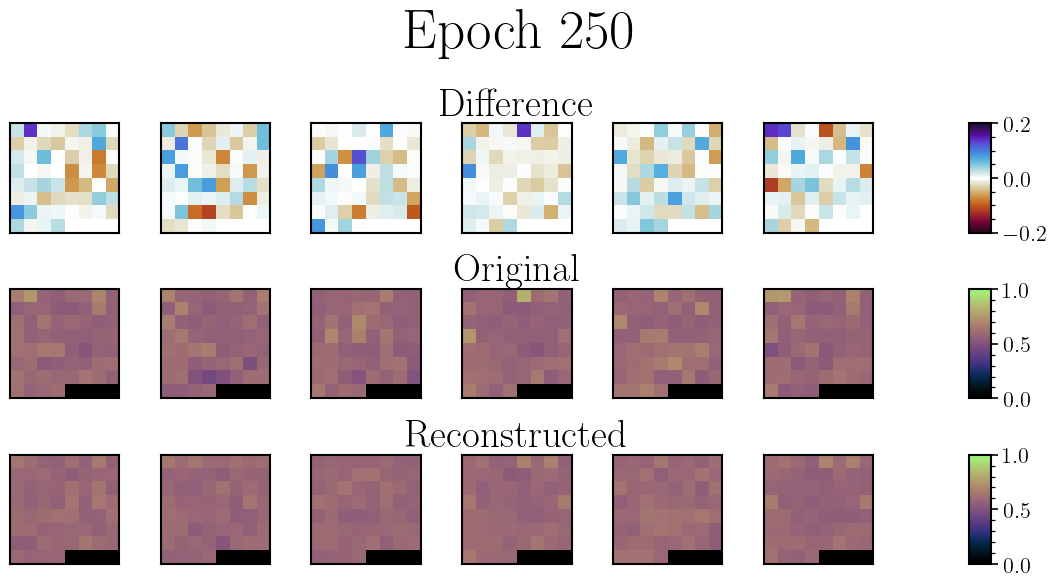

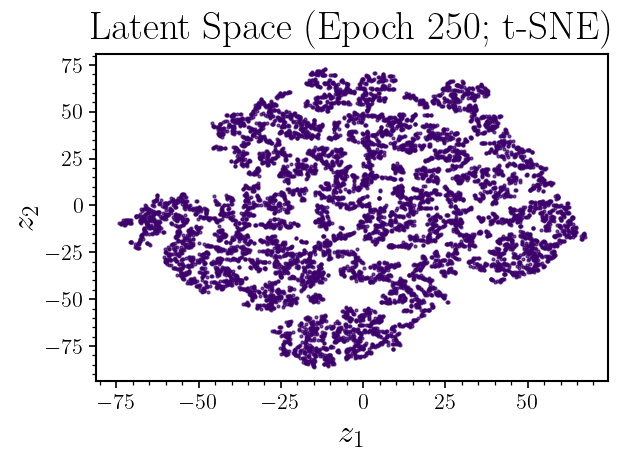

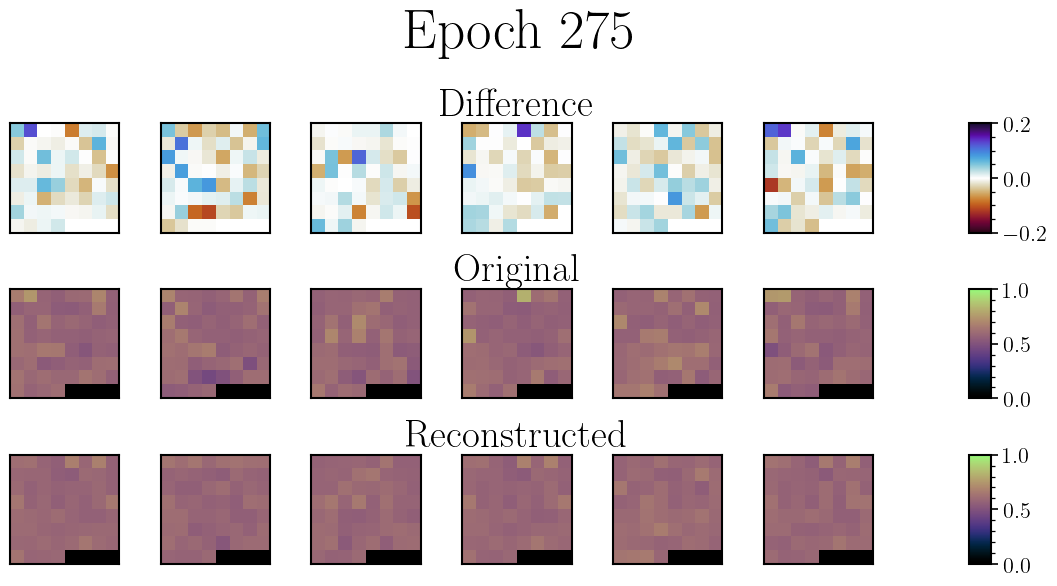

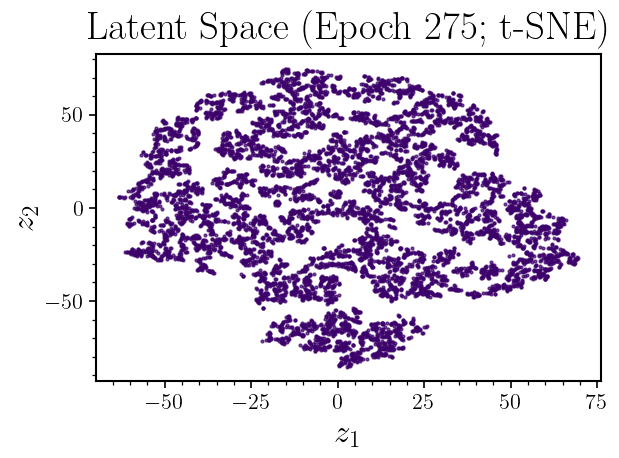

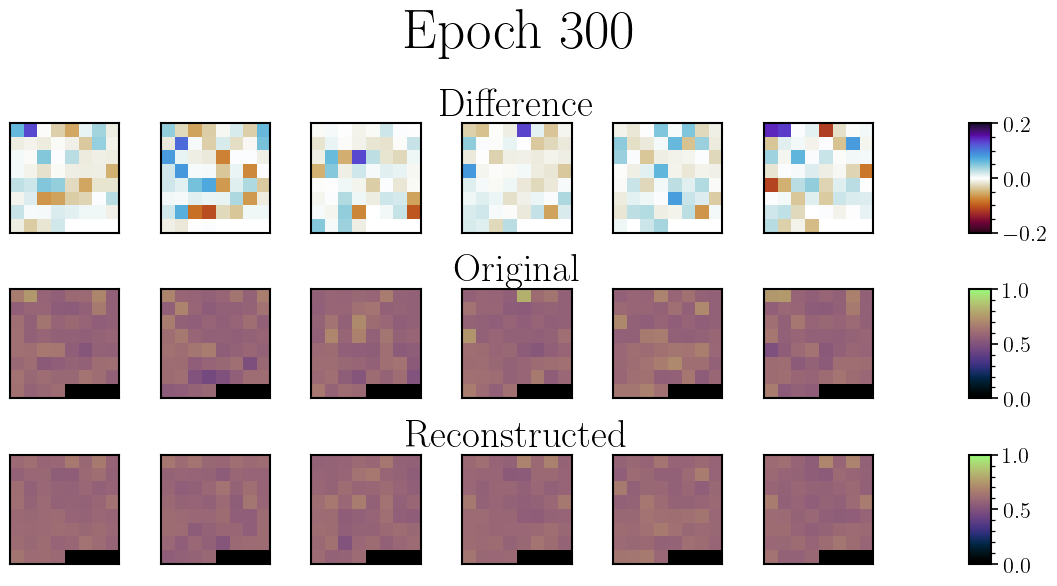

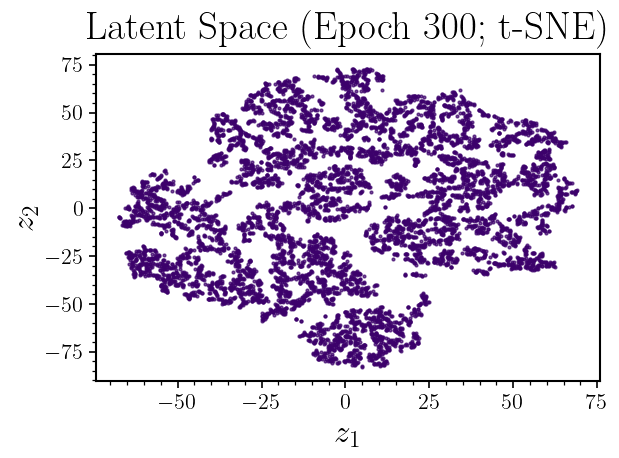

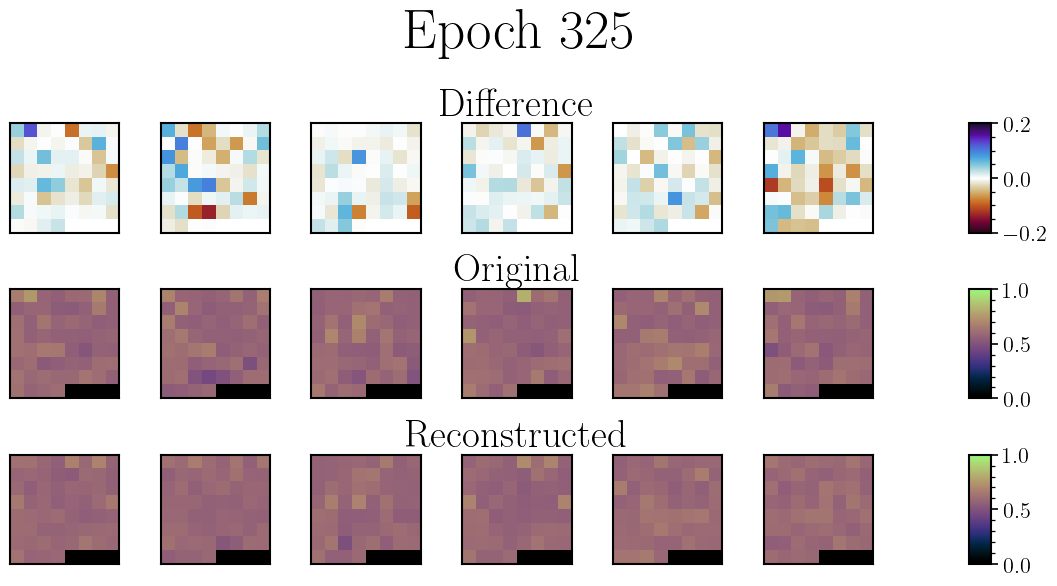

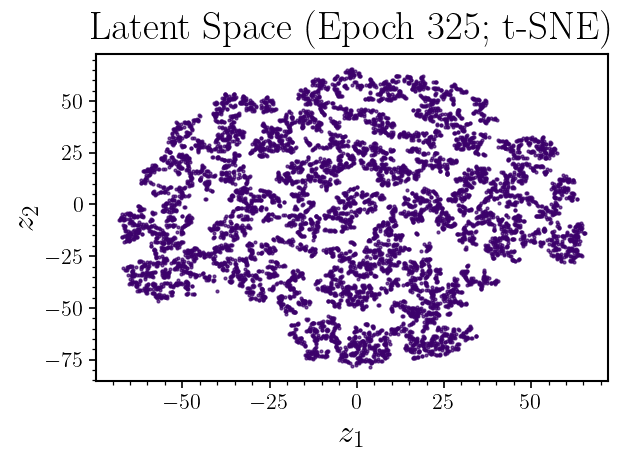

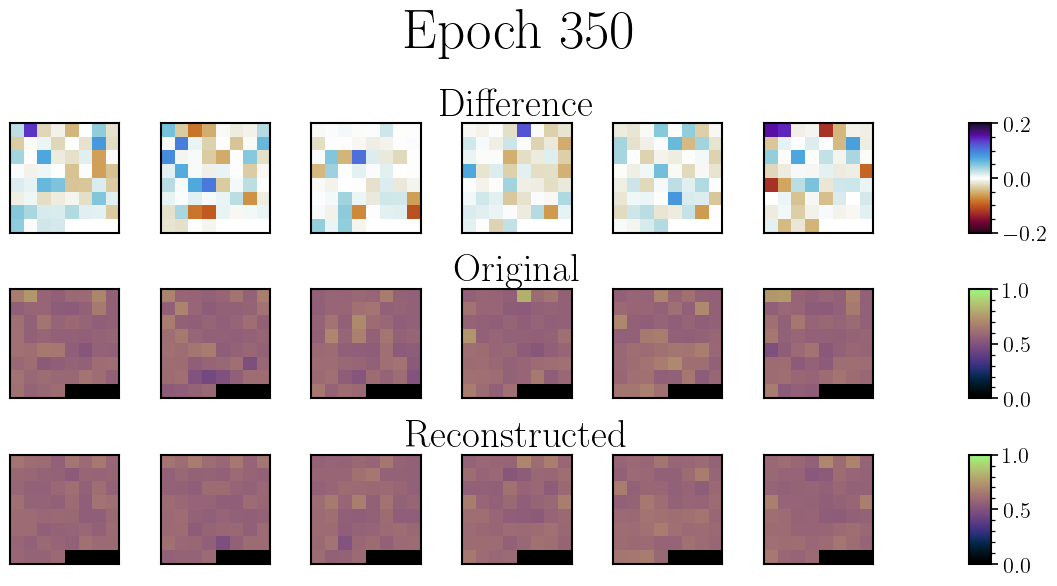

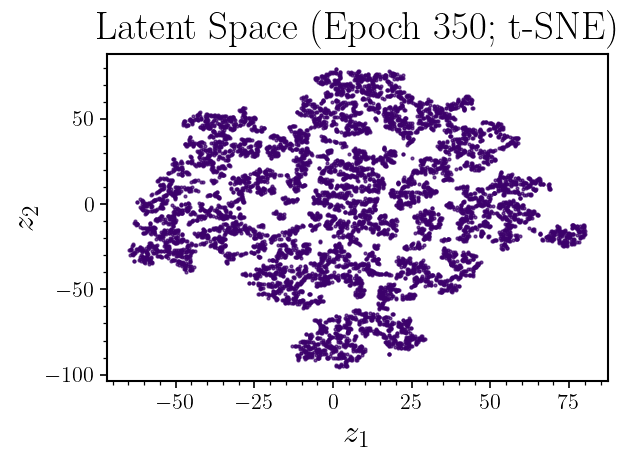

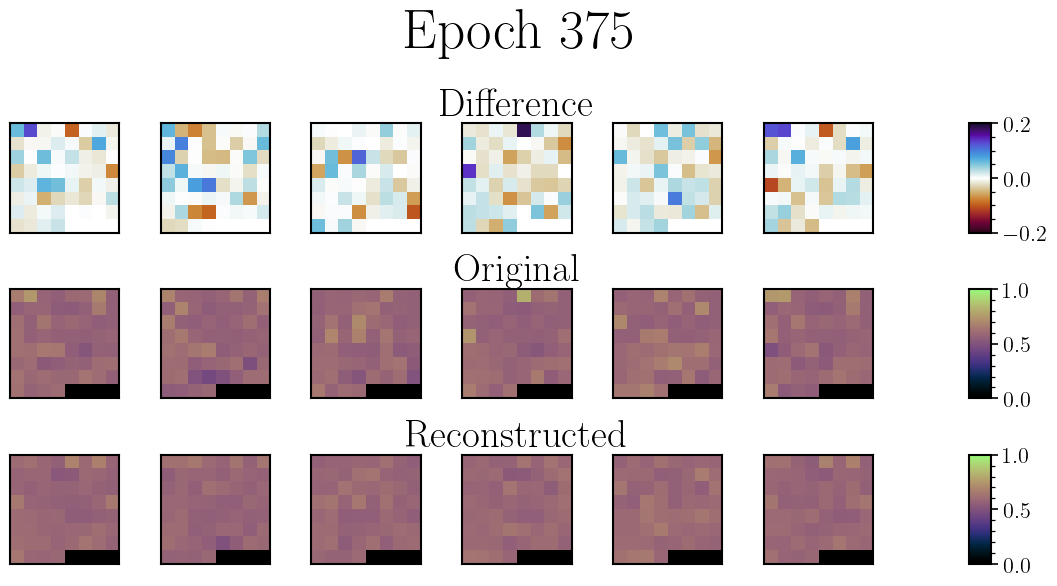

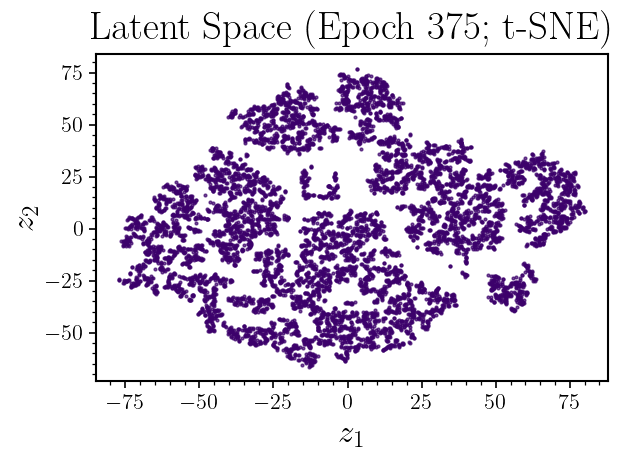

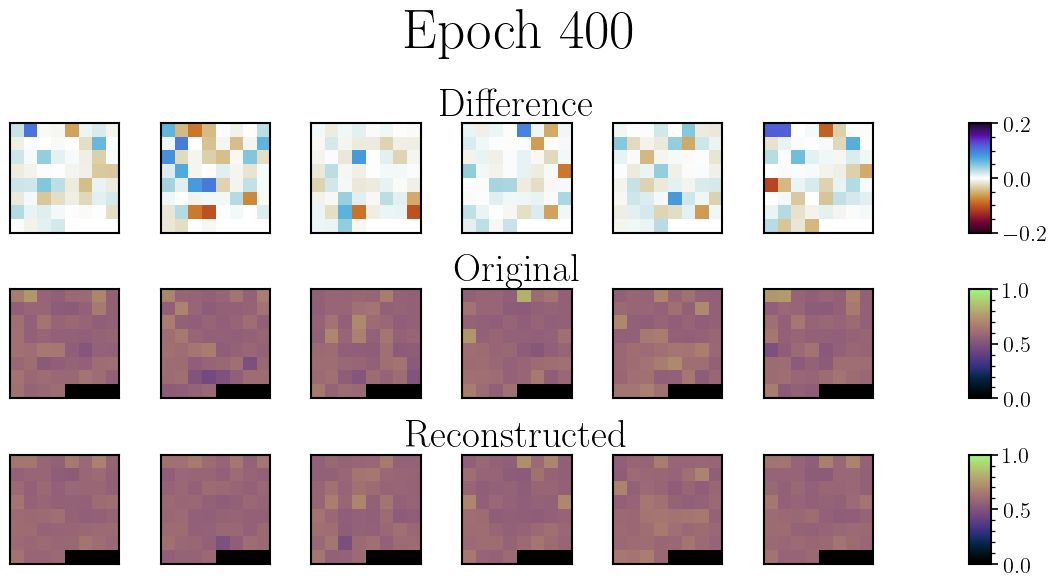

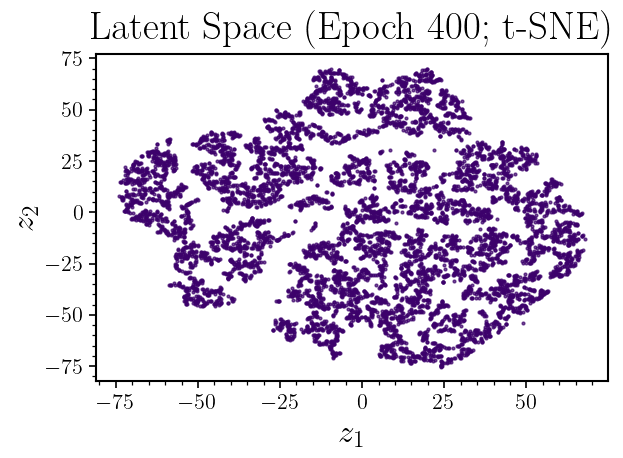

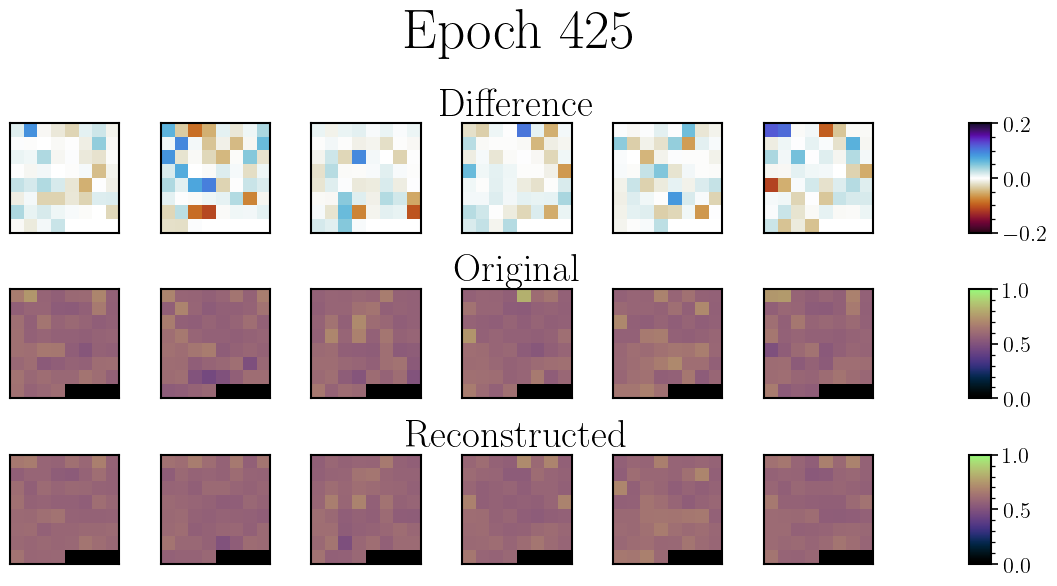

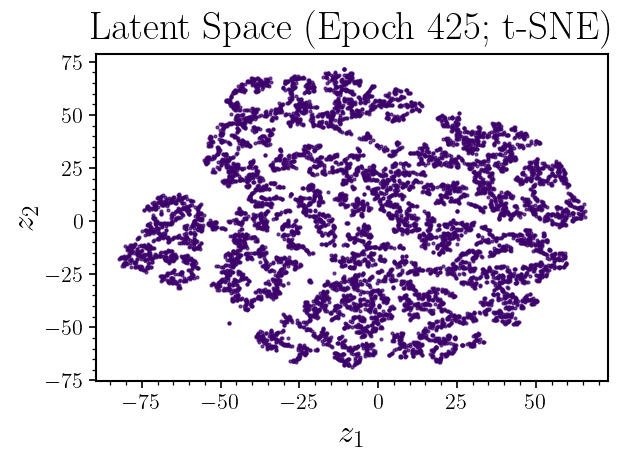

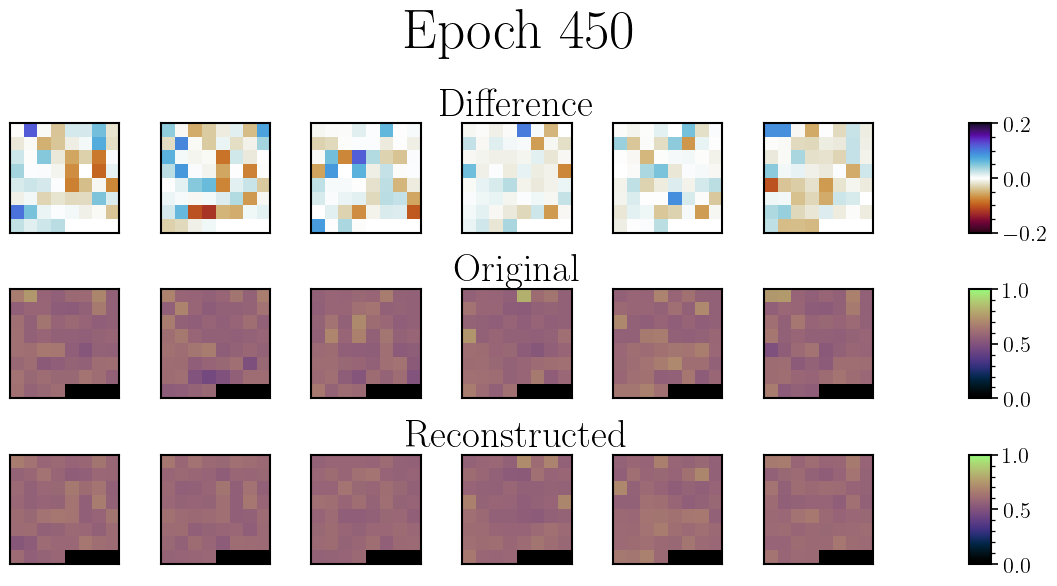

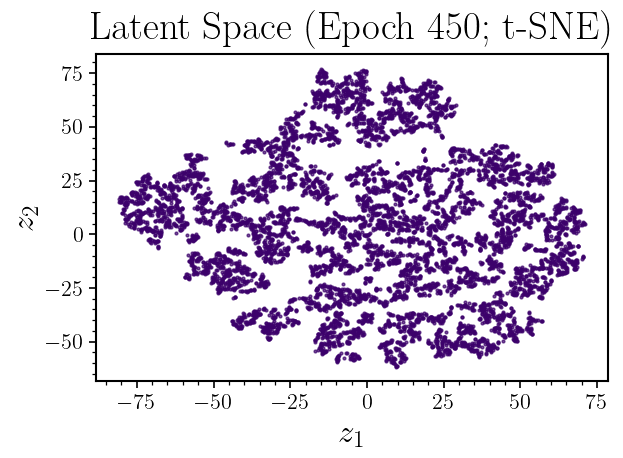

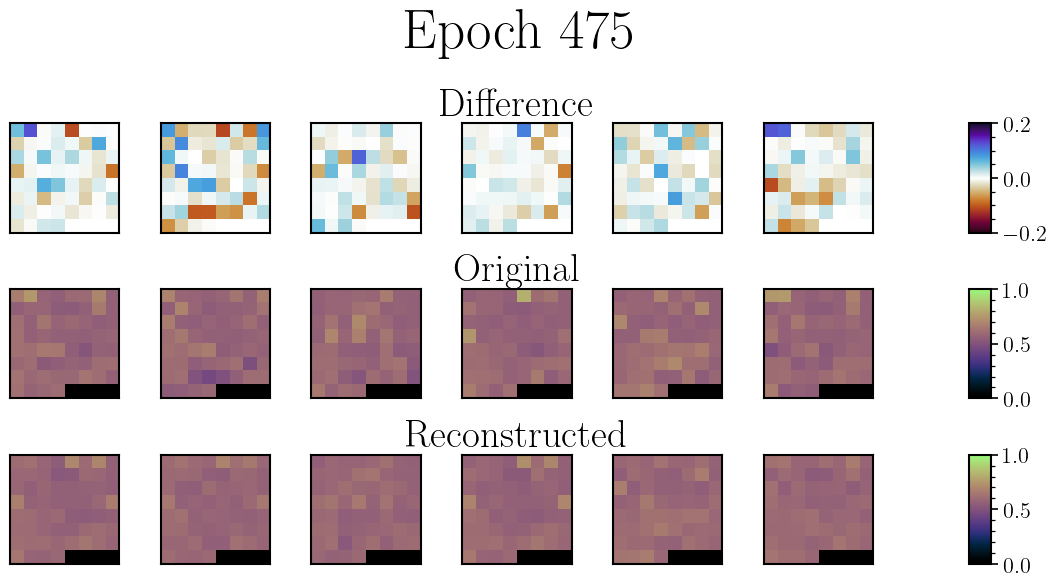

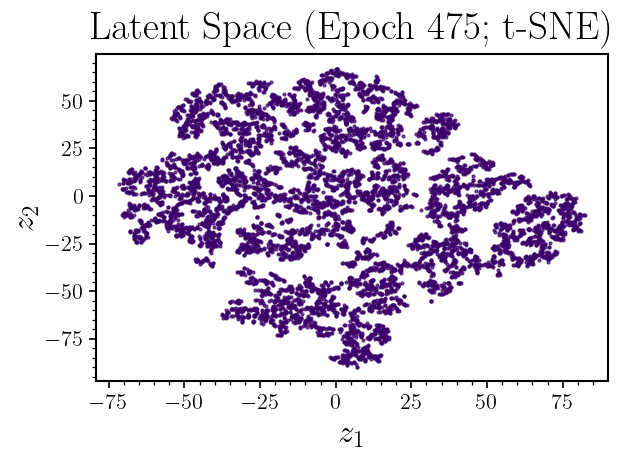

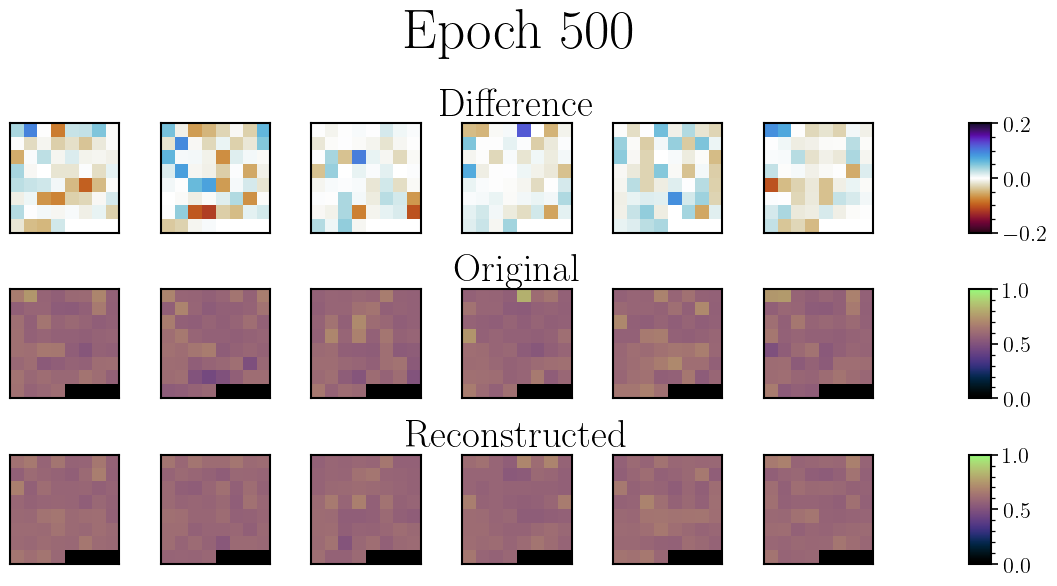

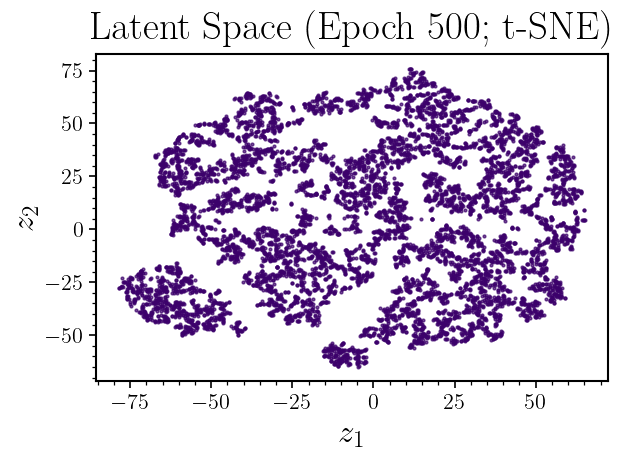

In [25]:
# create tensorboard writer
writer = SummaryWriter(dir_runs)
metrics = {
    "epoch": [],
    "Loss/train": [], 
    "Loss/train_recons": [],
    "Loss/train_kld": [],
    "Loss/val": [],
    "Loss/val_recons": [],
    "Loss/val_kld": []
}
fname = f"{dir_models}/vae-{tag}"
print(f"Tag: {tag}")

for epoch in tqdm(range(num_epochs), desc="Epochs", unit="epoch", total=num_epochs, colour="green"):
    # dump outputs
    if epoch % num_epoch_dump == 0:
        print(f"Writing data for epoch {epoch} of {num_epochs}")
        plot_ae_outputs(model, epoch, tag, n=6)
        plot_latent(model, train_loader, epoch, tag)
        torch.save(model.state_dict(), f"{fname}-epoch_{epoch}.pt")
    
    # train and test
    train_loss, train_recons, train_kld = train_epoch(
        vae=model,
        device=device,
        dataloader=train_loader,
        optimizer=optim)
    val_loss, val_recons, val_kld = test_epoch(
        vae=model,
        device=device,
        dataloader=test_loader, 
        verbose=True)

    # log metrics
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/train_recons", train_recons, epoch)
    writer.add_scalar("Loss/train_kld", train_kld, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("Loss/val_recons", val_recons, epoch)
    writer.add_scalar("Loss/val_kld", val_kld, epoch)
    writer.flush()
    metrics["epoch"].append(epoch)
    metrics["Loss/train"].append(train_loss)
    metrics["Loss/train_recons"].append(train_recons)
    metrics["Loss/train_kld"].append(train_kld)
    metrics["Loss/val"].append(val_loss)
    metrics["Loss/val_recons"].append(val_recons)
    metrics["Loss/val_kld"].append(val_kld)

# plot final outputs
plot_ae_outputs(model, num_epochs, tag, n=6)
plot_latent(model, train_loader, num_epochs, tag)

# save model
torch.save(model.state_dict(), f"{fname}-epoch_{num_epochs}.pt")
vae = model

# save indices of all data sets
np.savez_compressed(
    f"{dir_models}/indices-{tag}.npz",
    train=train_indices,
    test=test_indices,
    val=valid_indices
)
data_indices = {"train": train_indices, "test": test_indices, "val": valid_indices}

## 4. Evaluate model

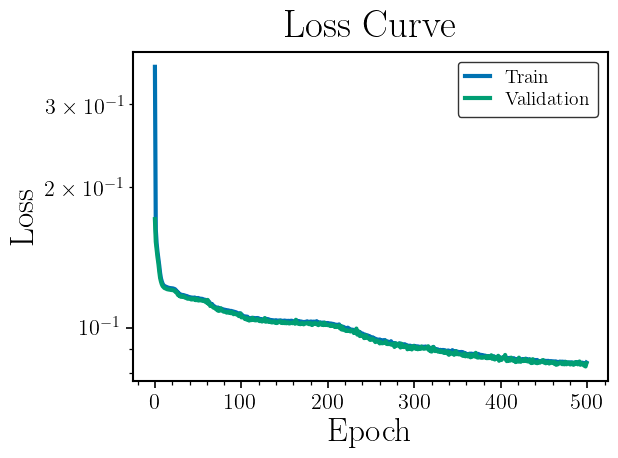

In [26]:
# plot the loss curve
fig, ax = plt.subplots()
fname = f"{dir_figures}/loss-{tag}"

ax.plot(range(num_epochs), metrics["Loss/train"], label="Train", linewidth=3)
ax.plot(range(num_epochs), metrics["Loss/val"], label="Validation", linewidth=3)

# convert y-axis to log scale
ax.set_yscale("log")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss Curve", y=1.02)
ax.legend()

fig.tight_layout()
fig.savefig(f"{fname}.png", dpi=300)


/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "


Final t-SNE KL divergence: 1.6122
Final t-SNE iterations: 10000
(13823, 2)


/tmp/ipykernel_2432242/1494170200.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "


Final t-SNE KL divergence: 1.8933
Final t-SNE iterations: 10000
(13823, 2)


/tmp/ipykernel_2432242/1494170200.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "


Final t-SNE KL divergence: 1.8756
Final t-SNE iterations: 10000
(13823, 2)


/tmp/ipykernel_2432242/1494170200.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "


Final t-SNE KL divergence: 1.7936
Final t-SNE iterations: 10000
(13823, 2)


/tmp/ipykernel_2432242/1494170200.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "


Final t-SNE KL divergence: 1.6999
Final t-SNE iterations: 9700
(13823, 2)


/tmp/ipykernel_2432242/1494170200.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


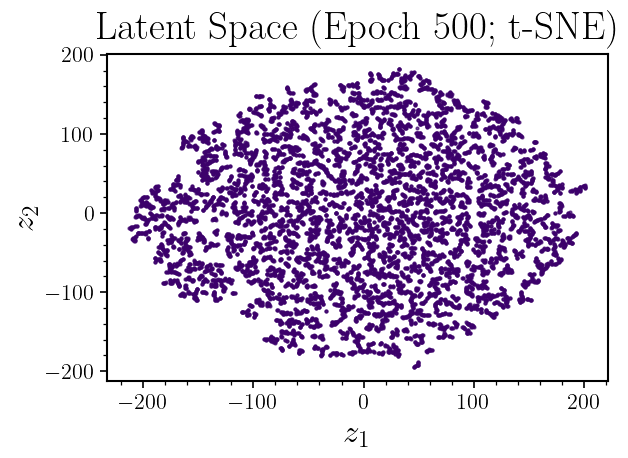

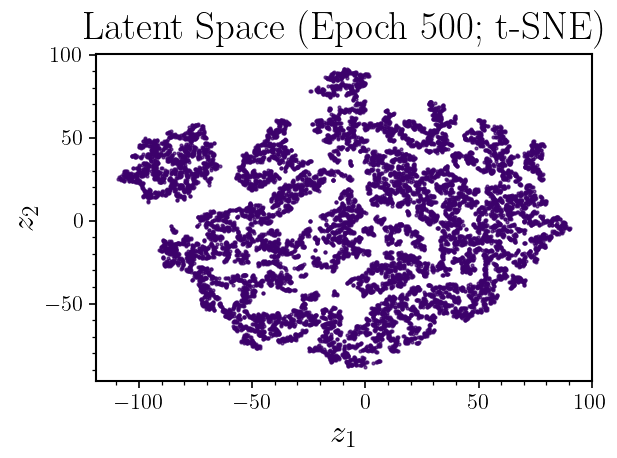

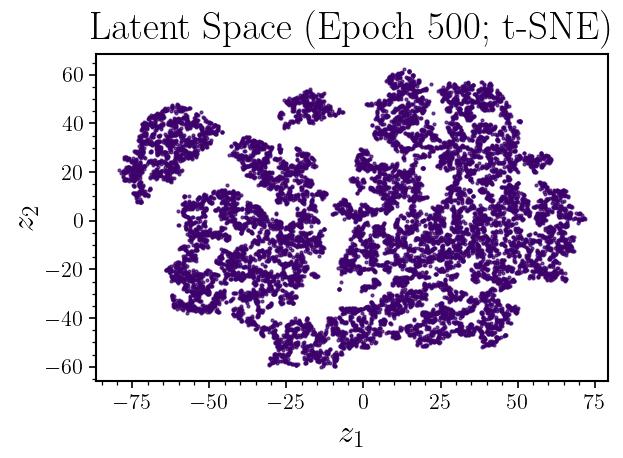

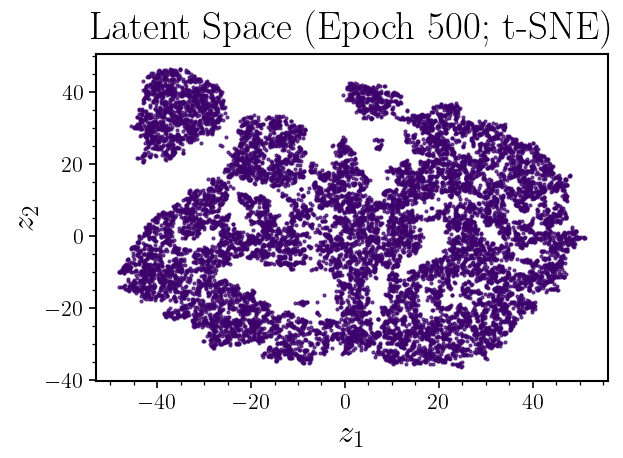

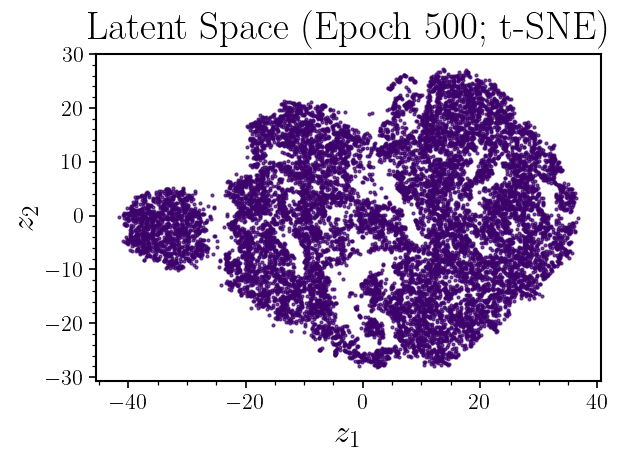

In [27]:
# plot final latent space
n_iter = 10000
perplexities = [5, 30, 50, 100, 200]

for perplexity in perplexities:
    tsne_tag = f"tsne-perplexity_{perplexity}-n_iter_{n_iter}"
    out_tag = f"{tsne_tag}-{tag}"
    fig, ax = plot_latent(vae, all_loader, num_epochs, out_tag, perplexity=perplexity, n_iter=n_iter)
    fig.show()

## 5. Visualize results

In [28]:
def fit_tsne(datal: DataLoader, vae: VariationalAutoencoder, perplexity: int = 30, n_iter: int = 10000, seed: int = 42, verbose: bool = False) -> tuple[np.ndarray, TSNE]:
    # iterate over data loader to get all data
    dat = []
    for i, data in enumerate(datal):
        dat.append(data)
    dat = torch.cat(dat)
    z = vae.encoder(dat.to(device))
    z = z.to('cpu').detach().numpy()
    if verbose:
        print(f"Data shape: {z.shape}")
    
    # if number of columns is 2, return
    if z.shape[1] == 2:
        return z, None

    # fit t-SNE
    vout = 4 if verbose else 0
    mod = TSNE(
        n_components=2,
        perplexity=perplexity,
        n_iter=n_iter,
        verbose=vout,
        n_jobs=-1,
    )
    z_red = mod.fit_transform(z)
    if verbose:
        print(f"Final t-SNE KL divergence: {mod.kl_divergence_:.4f}")
        print(f"Final t-SNE iterations: {mod.n_iter_+1}")

    return z_red, mod


/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "
/tmp/ipykernel_2432242/2412668622.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "
/tmp/ipykernel_2432242/2412668622.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so c

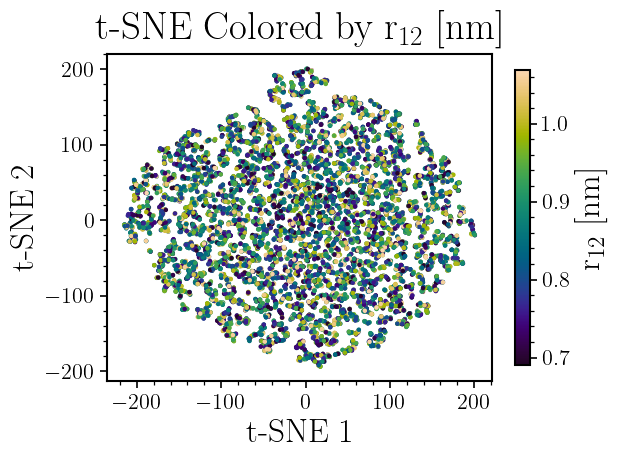

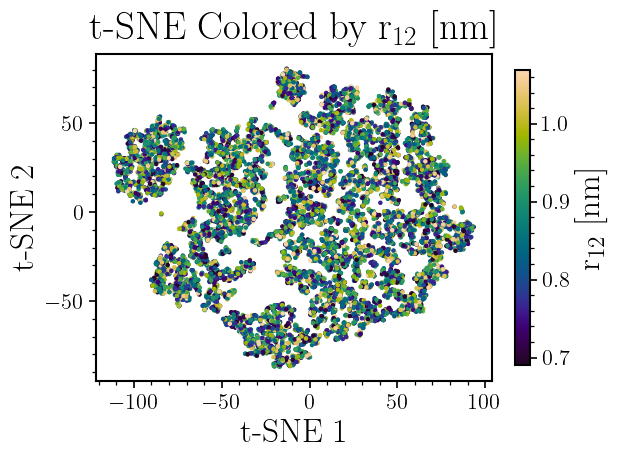

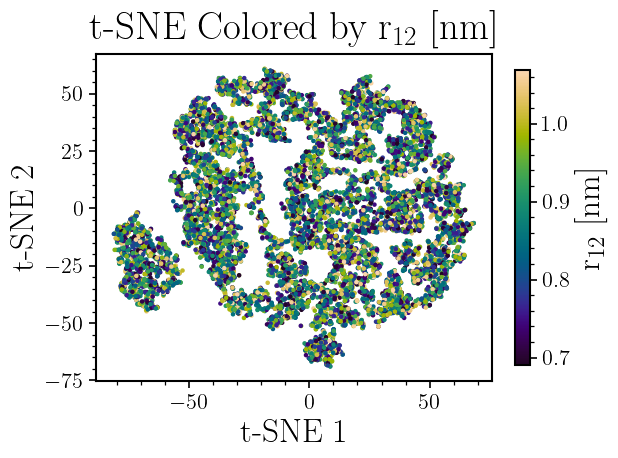

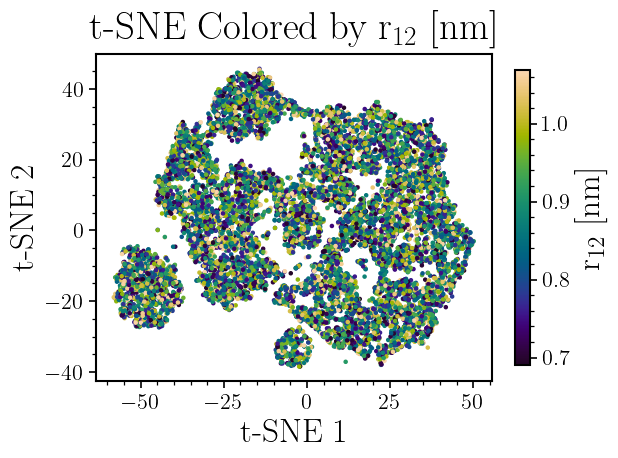

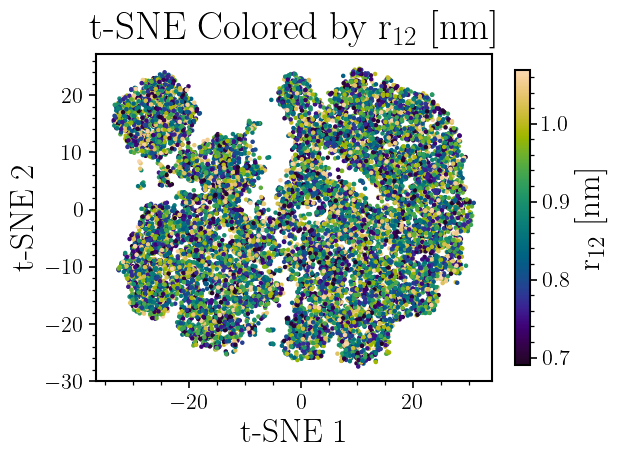

In [29]:
# plot t-SNE colored by third variable
col, col_label = "d12", r"r$_{12}$ [nm]"
cmap = cmr.get_sub_cmap("cmr.rainforest", 0.1, 0.9)

for perplexity in perplexities:
    tsne_tag = f"tsne-perplexity_{perplexity}-n_iter_{n_iter}"
    fname = f"{dir_figures}/tsne-{tag}-{tsne_tag}-colored_by_{col}"

    # fit t-SNE using all data
    z_red, mod_tsne = fit_tsne(all_loader, vae=model, perplexity=perplexity, n_iter=n_iter, seed=seed, verbose=False)
    df_t = pd.DataFrame(z_red, columns=["t-SNE 1", "t-SNE 2"])
    df_t.to_parquet(f"{dir_models}/{tsne_tag}-{tag}.parquet")

    # merge all data
    df = pd.concat([features_unscaled, dynamics], axis=1)
    df_t = pd.concat([df, df_t], axis=1)

    # gather data for plotting
    x, y, z = df_t["t-SNE 1"].copy(), df_t["t-SNE 2"].copy(), df_t[col].copy()
    if col == "d12":
        z /= 10.

    # create figure
    fig, ax = plt.subplots()
    sc = ax.scatter(x, y, c=z, cmap=cmap, s=5)
    fig.colorbar(sc, ax=ax, shrink=0.9, fraction=0.1, pad=0.05, label=col_label)

    # figure elements
    ax.set_xlabel(r"t-SNE 1")
    ax.set_ylabel(r"t-SNE 2")
    ax.set_title(f"t-SNE Colored by {col_label}", y=1.02)

    # save figure
    fig.tight_layout()
    fig.savefig(f"{fname}.png", dpi=300)
    fig.show()


/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "
/tmp/ipykernel_2432242/2663861659.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/aglisman/miniconda3/envs/ml/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "
/tmp/ipykernel_2432242/2663861659.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so c

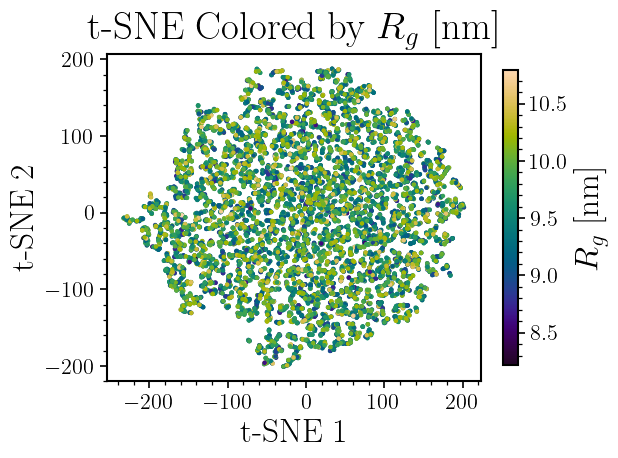

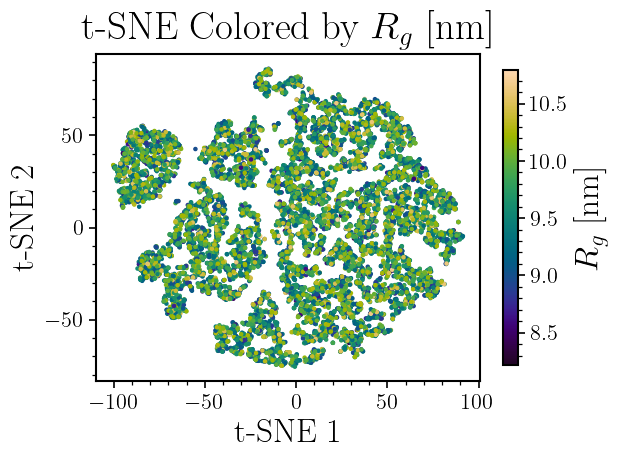

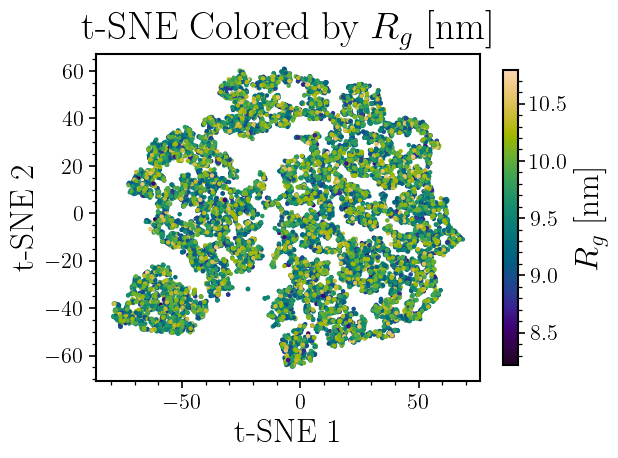

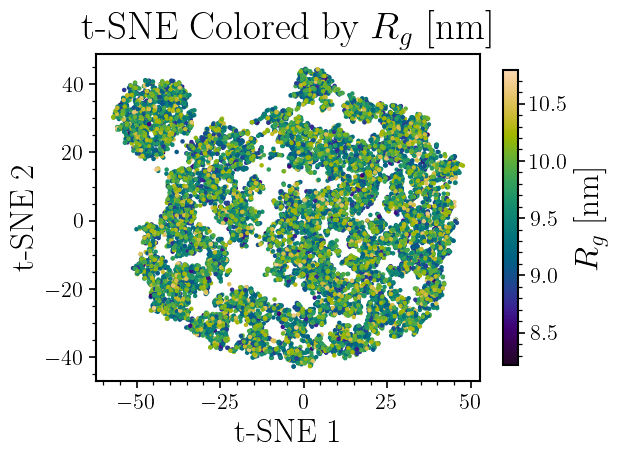

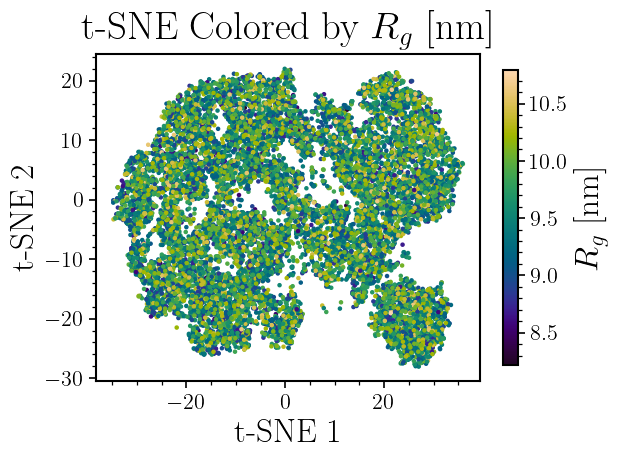

In [30]:
# plot t-SNE colored by third variable
col, col_label = "rg_avg", r"$R_g$ [nm]"
cmap = cmr.get_sub_cmap("cmr.rainforest", 0.1, 0.9)

for perplexity in perplexities:
    tsne_tag = f"tsne-perplexity_{perplexity}-n_iter_{n_iter}"
    fname = f"{dir_figures}/tsne-{tag}-{tsne_tag}-colored_by_{col}"

    # fit t-SNE using all data
    z_red, mod_tsne = fit_tsne(all_loader, vae=model, perplexity=perplexity, n_iter=n_iter, seed=seed, verbose=False)
    df_t = pd.DataFrame(z_red, columns=["t-SNE 1", "t-SNE 2"])
    df_t.to_parquet(f"{dir_models}/{tsne_tag}-{tag}.parquet")

    # merge all data
    df = pd.concat([features_unscaled, dynamics], axis=1)
    df_t = pd.concat([df, df_t], axis=1)

    # gather data for plotting
    x, y = df_t["t-SNE 1"].copy(), df_t["t-SNE 2"].copy()
    z = (df_t["Rg_0"] + df_t["Rg_1"]) / 2.

    # create figure
    fig, ax = plt.subplots()
    sc = ax.scatter(x, y, c=z, cmap=cmap, s=5)
    fig.colorbar(sc, ax=ax, shrink=0.9, fraction=0.1, pad=0.05, label=col_label)

    # figure elements
    ax.set_xlabel(r"t-SNE 1")
    ax.set_ylabel(r"t-SNE 2")
    ax.set_title(f"t-SNE Colored by {col_label}", y=1.02)

    # save figure
    fig.tight_layout()
    fig.savefig(f"{fname}.png", dpi=300)
    fig.show()
